In [1]:
## 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [2]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [3]:
dataX = data.copy().drop(['Class','Time'],axis=1)

In [4]:
dataY = data['Class'].copy()

In [5]:
# 데이터 스케일

In [6]:
featuresToScale = dataX.columns

In [7]:
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

In [8]:
# 훈련 및 테스트 셋으로 분할 

In [9]:
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [10]:
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

In [11]:
# 평가 함수(이상치 스코어 함수) 및 그래프 함수 정의

In [12]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [13]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision  ### diff

In [14]:
# 모델 1
# 선형 활성화 함수로 구성된 2-계층 완전오토인코더

In [15]:
# 신경망 API 호출
model = Sequential()

# 입력층에 선형 활성화 함수 적용
# 입력 계층과 동일한 29개 노드를 가진 은닉층 생성
model.add(Dense(units=29, activation='linear',input_dim=29))

# 은닉층에 선형 활성화 함수 적용
# 29개 노드를 가진 출력층 생성
model.add(Dense(units=29, activation='linear'))

In [16]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [17]:
# 모델 훈련
num_epochs = 10
batch_size = 32

history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)



Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0703 - acc: 0.9041 - val_loss: 6.4339e-04 - val_acc: 0.9910
Epoch 2/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.0011 - acc: 0.9930 - val_loss: 1.2076e-07 - val_acc: 0.9998
Epoch 3/10
190820/190820 [==============================] - 10s 53us/step - loss: 8.9824e-04 - acc: 0.9938 - val_loss: 1.0248e-08 - val_acc: 0.9999
Epoch 4/10
190820/190820 [==============================] - 10s 54us/step - loss: 5.6774e-04 - acc: 0.9936 - val_loss: 6.0319e-06 - val_acc: 0.9992
Epoch 5/10
190820/190820 [==============================] - 10s 53us/step - loss: 4.1158e-04 - acc: 0.9944 - val_loss: 5.7475e-04 - val_acc: 0.9968
Epoch 6/10
190820/190820 [==============================] - 10s 53us/step - loss: 7.1051e-04 - acc: 0.9940 - val_loss: 0.0014 - val_acc: 0.9901
Epoch 7/10
190820/190820 [==============================] - 10s 53us/s

93987/93987 [==============================] - 1s 9us/step


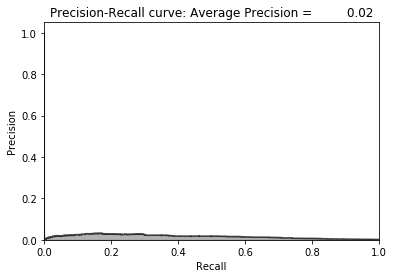

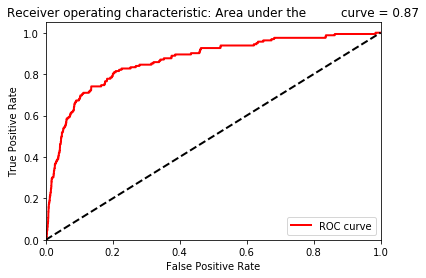

In [18]:
# 테스트 셋에 대한 평가
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.0766 - acc: 0.9029 - val_loss: 0.0013 - val_acc: 0.9903
Epoch 2/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.0011 - acc: 0.9906 - val_loss: 3.0005e-06 - val_acc: 0.9990
Epoch 3/10
190820/190820 [==============================] - 10s 53us/step - loss: 6.8181e-04 - acc: 0.9944 - val_loss: 8.9357e-05 - val_acc: 0.9977
Epoch 4/10
190820/190820 [==============================] - 10s 53us/step - loss: 8.5035e-04 - acc: 0.9943 - val_loss: 3.6447e-07 - val_acc: 0.9998
Epoch 5/10
190820/190820 [==============================] - 10s 53us/step - loss: 5.1933e-04 - acc: 0.9944 - val_loss: 7.9995e-05 - val_acc: 0.9960
Epoch 6/10
190820/190820 [==============================] - 10s 53us/step - loss: 5.5684e-04 - acc: 0.9939 - val_loss: 0.0051 - val_acc: 0.9867
Epoch 7/10
190820/190820 [==============================] - 10s 53us/step - 

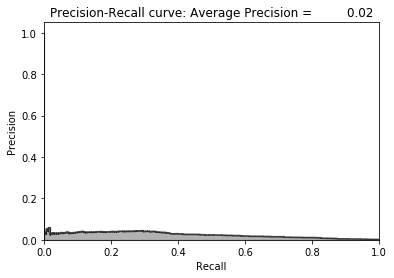

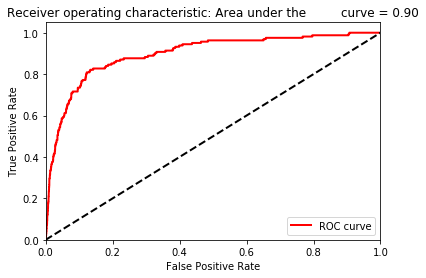

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0788 - acc: 0.8927 - val_loss: 0.0014 - val_acc: 0.9864
Epoch 2/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.0015 - acc: 0.9907 - val_loss: 0.0077 - val_acc: 0.9692
Epoch 3/10
190820/190820 [==============================] - 10s 54us/step - loss: 5.8066e-04 - acc: 0.9958 - val_loss: 0.0014 - val_acc: 0.9905
Epoch 4/10
190820/190820 [==============================] - 10s 54us/step - loss: 7.2221e-04 - acc: 0.9919 - val_loss: 0.0016 - val_acc: 0.9866
Epoch 5/10
190820/190820 [==============================] - 10s 54us/step - loss: 7.6263e-04 - acc: 0.9950 - val_loss: 0.0032 - val_acc: 0.9777
Epoch 6/10
190820/190820 [==============================] - 10s 54us/step - loss: 4.5944e-04 - acc: 0.9955 - val_loss: 3.4825e-07 - val_acc: 0.9996
Epoch 7/10
190820/190820 [==============================] - 11s 58us/step - loss: 6.4686

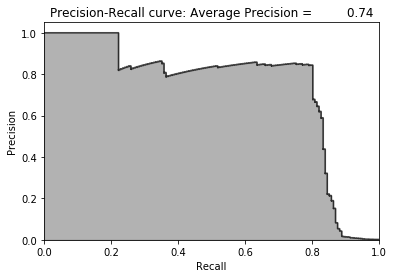

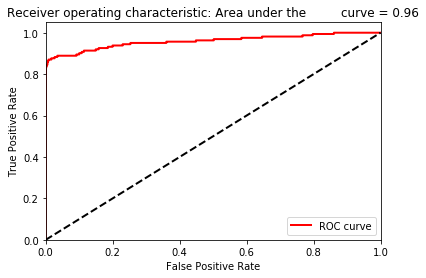

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0895 - acc: 0.8894 - val_loss: 0.0019 - val_acc: 0.9898
Epoch 2/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0023 - acc: 0.9853 - val_loss: 0.0044 - val_acc: 0.9614
Epoch 3/10
190820/190820 [==============================] - 11s 56us/step - loss: 4.4984e-04 - acc: 0.9943 - val_loss: 2.8205e-08 - val_acc: 0.9999
Epoch 4/10
190820/190820 [==============================] - 11s 56us/step - loss: 5.7109e-04 - acc: 0.9928 - val_loss: 5.5669e-04 - val_acc: 0.9829
Epoch 5/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0012 - acc: 0.9934 - val_loss: 1.4282e-05 - val_acc: 0.9989
Epoch 6/10
190820/190820 [==============================] - 11s 56us/step - loss: 3.3029e-04 - acc: 0.9965 - val_loss: 1.6923e-05 - val_acc: 0.9984
Epoch 7/10
190820/190820 [==============================] - 11s 56us/step - loss

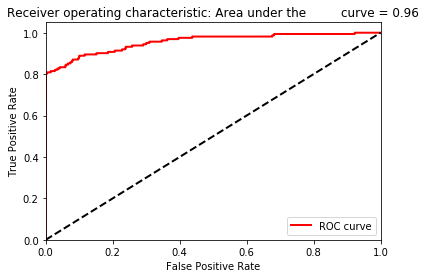

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.1162 - acc: 0.8525 - val_loss: 0.0019 - val_acc: 0.9900
Epoch 2/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0018 - acc: 0.9869 - val_loss: 1.0093e-04 - val_acc: 0.9964
Epoch 3/10
190820/190820 [==============================] - 11s 57us/step - loss: 8.0254e-04 - acc: 0.9936 - val_loss: 2.7583e-05 - val_acc: 0.9985
Epoch 4/10
190820/190820 [==============================] - 11s 57us/step - loss: 9.2129e-04 - acc: 0.9936 - val_loss: 2.8112e-06 - val_acc: 0.9994
Epoch 5/10
190820/190820 [==============================] - 11s 57us/step - loss: 3.2320e-04 - acc: 0.9965 - val_loss: 4.6100e-04 - val_acc: 0.9903
Epoch 6/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0010 - acc: 0.9932 - val_loss: 1.1604e-04 - val_acc: 0.9950
Epoch 7/10
190820/190820 [==============================] - 11s 58us/step - 

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0772 - acc: 0.9055 - val_loss: 0.0018 - val_acc: 0.9833
Epoch 2/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.0013 - acc: 0.9897 - val_loss: 1.4570e-04 - val_acc: 0.9926
Epoch 3/10
190820/190820 [==============================] - 11s 57us/step - loss: 6.7338e-04 - acc: 0.9936 - val_loss: 1.1658e-05 - val_acc: 0.9984
Epoch 4/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0011 - acc: 0.9940 - val_loss: 3.2806e-06 - val_acc: 0.9990
Epoch 5/10
190820/190820 [==============================] - 11s 57us/step - loss: 6.2428e-04 - acc: 0.9942 - val_loss: 3.0177e-05 - val_acc: 0.9983
Epoch 6/10
190820/190820 [==============================] - 11s 59us/step - loss: 7.0370e-04 - acc: 0.9942 - val_loss: 1.7013e-05 - val_acc: 0.9985
Epoch 7/10
190820/190820 [==============================] - 11s 58us/step - 

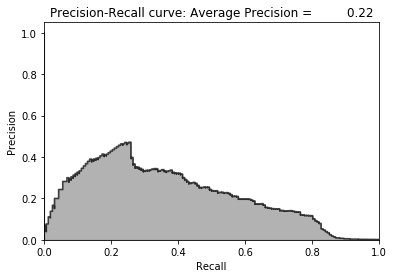

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0803 - acc: 0.8858 - val_loss: 0.0022 - val_acc: 0.9771
Epoch 2/10
190820/190820 [==============================] - 11s 58us/step - loss: 8.9057e-04 - acc: 0.9909 - val_loss: 1.1314e-04 - val_acc: 0.9974
Epoch 3/10
190820/190820 [==============================] - 11s 58us/step - loss: 6.8812e-04 - acc: 0.9938 - val_loss: 0.0020 - val_acc: 0.9807
Epoch 4/10
190820/190820 [==============================] - 11s 58us/step - loss: 5.6445e-04 - acc: 0.9939 - val_loss: 1.3637e-04 - val_acc: 0.9956
Epoch 5/10
190820/190820 [==============================] - 11s 58us/step - loss: 4.1694e-04 - acc: 0.9940 - val_loss: 0.0026 - val_acc: 0.9810
Epoch 6/10
190820/190820 [==============================] - 11s 58us/step - loss: 6.7445e-04 - acc: 0.9936 - val_loss: 2.7688e-05 - val_acc: 0.9969
Epoch 7/10
190820/190820 [==============================] - 11s 58us/step - 

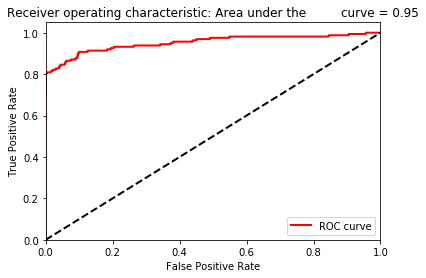

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0676 - acc: 0.9003 - val_loss: 0.0019 - val_acc: 0.9864
Epoch 2/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0016 - acc: 0.9888 - val_loss: 5.5575e-06 - val_acc: 0.9994
Epoch 3/10
190820/190820 [==============================] - 11s 59us/step - loss: 7.1928e-04 - acc: 0.9944 - val_loss: 0.0067 - val_acc: 0.9870
Epoch 4/10
190820/190820 [==============================] - 11s 58us/step - loss: 5.6163e-04 - acc: 0.9937 - val_loss: 6.3268e-08 - val_acc: 0.9999
Epoch 5/10
190820/190820 [==============================] - 11s 59us/step - loss: 7.5906e-04 - acc: 0.9940 - val_loss: 5.4920e-04 - val_acc: 0.9833
Epoch 6/10
190820/190820 [==============================] - 11s 59us/step - loss: 5.4640e-04 - acc: 0.9950 - val_loss: 8.7640e-06 - val_acc: 0.9991
Epoch 7/10
190820/190820 [==============================] - 11s 59us/step - 

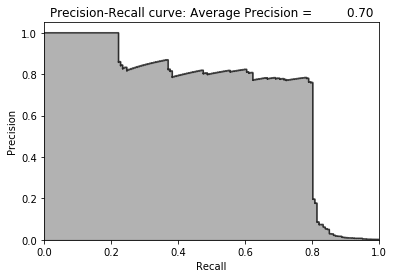

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.0851 - acc: 0.8922 - val_loss: 0.0011 - val_acc: 0.9882
Epoch 2/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0011 - acc: 0.9923 - val_loss: 0.0050 - val_acc: 0.9662
Epoch 3/10
190820/190820 [==============================] - 11s 58us/step - loss: 4.7145e-04 - acc: 0.9947 - val_loss: 0.0016 - val_acc: 0.9956
Epoch 4/10
190820/190820 [==============================] - 11s 59us/step - loss: 5.9132e-04 - acc: 0.9948 - val_loss: 1.8485e-05 - val_acc: 0.9990
Epoch 5/10
190820/190820 [==============================] - 11s 59us/step - loss: 6.1704e-04 - acc: 0.9934 - val_loss: 1.1633e-05 - val_acc: 0.9986
Epoch 6/10
190820/190820 [==============================] - 11s 58us/step - loss: 4.6634e-04 - acc: 0.9942 - val_loss: 3.6968e-06 - val_acc: 0.9997
Epoch 7/10
190820/190820 [==============================] - 11s 59us/step - loss

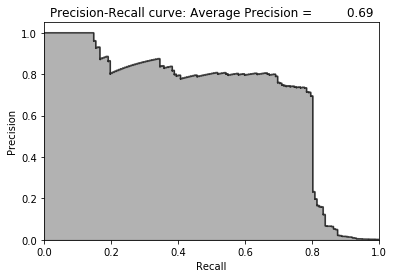

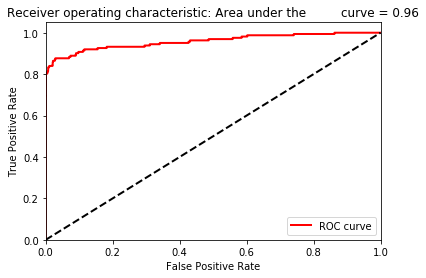

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.0990 - acc: 0.8777 - val_loss: 0.0018 - val_acc: 0.9876
Epoch 2/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0021 - acc: 0.9859 - val_loss: 7.6291e-04 - val_acc: 0.9833
Epoch 3/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0014 - acc: 0.9938 - val_loss: 2.1394e-07 - val_acc: 0.9997
Epoch 4/10
190820/190820 [==============================] - 11s 59us/step - loss: 6.9144e-04 - acc: 0.9955 - val_loss: 1.8683e-06 - val_acc: 0.9993
Epoch 5/10
190820/190820 [==============================] - 11s 60us/step - loss: 6.6323e-04 - acc: 0.9938 - val_loss: 1.0486e-04 - val_acc: 0.9959
Epoch 6/10
190820/190820 [==============================] - 12s 60us/step - loss: 5.2961e-04 - acc: 0.9945 - val_loss: 3.1252e-06 - val_acc: 0.9993
Epoch 7/10
190820/190820 [==============================] - 11s 60us/step - 

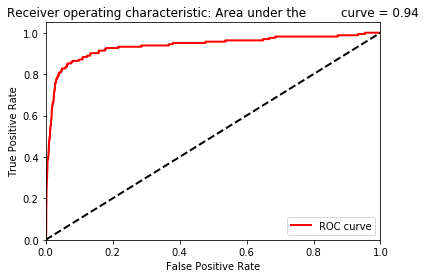

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.1009 - acc: 0.8819 - val_loss: 0.0047 - val_acc: 0.9773
Epoch 2/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0024 - acc: 0.9839 - val_loss: 0.0021 - val_acc: 0.9865
Epoch 3/10
190820/190820 [==============================] - 12s 60us/step - loss: 0.0018 - acc: 0.9870 - val_loss: 6.8444e-05 - val_acc: 0.9978
Epoch 4/10
190820/190820 [==============================] - 11s 60us/step - loss: 5.9350e-04 - acc: 0.9942 - val_loss: 1.7503e-05 - val_acc: 0.9985
Epoch 5/10
190820/190820 [==============================] - 11s 60us/step - loss: 7.0179e-04 - acc: 0.9948 - val_loss: 2.5792e-06 - val_acc: 0.9995
Epoch 6/10
190820/190820 [==============================] - 12s 61us/step - loss: 7.7434e-04 - acc: 0.9943 - val_loss: 1.7928e-05 - val_acc: 0.9986
Epoch 7/10
190820/190820 [==============================] - 12s 61us/step - loss

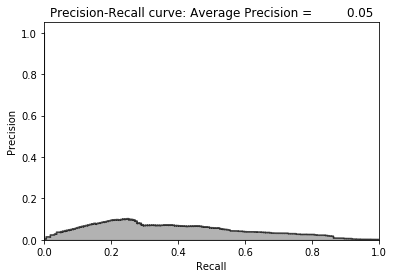

Mean average precision over 10 runs:  0.411722673694985


[0.024079934756640616,
 0.7393369188838209,
 0.6900212123468878,
 0.2752136463233382,
 0.22016131742510708,
 0.6685487988264109,
 0.6979308379268822,
 0.687224854277456,
 0.06714976787229207,
 0.047559448311014246]

In [19]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 입력층에 선형 활성화 함수 적용
    # 입력층과 동일한 29개 노드를 가진 은닉층 생성
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # 은닉층에 선형 활성화 함수 적용
    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [20]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.411722673694985
Coefficient of variation over 10 runs:  0.7145436695016697


[0.024079934756640616,
 0.7393369188838209,
 0.6900212123468878,
 0.2752136463233382,
 0.22016131742510708,
 0.6685487988264109,
 0.6979308379268822,
 0.687224854277456,
 0.06714976787229207,
 0.047559448311014246]

In [21]:
# 모델 2
# 선형 활성화 함수를 가진 2-계층 과소완전 오토인코더(은닉층 20개 노드)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.3715 - acc: 0.5270 - val_loss: 0.2806 - val_acc: 0.5986
Epoch 2/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2841 - acc: 0.6031 - val_loss: 0.2774 - val_acc: 0.6065
Epoch 3/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2804 - acc: 0.6108 - val_loss: 0.2767 - val_acc: 0.6191
Epoch 4/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2798 - acc: 0.6178 - val_loss: 0.2818 - val_acc: 0.6144
Epoch 5/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.2778 - acc: 0.6038 - val_loss: 0.2749 - val_acc: 0.6128
Epoch 6/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2785 - acc: 0.6075 - val_loss: 0.2749 - val_acc: 0.6019
Epoch 7/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2783 - acc: 0.6029 - val

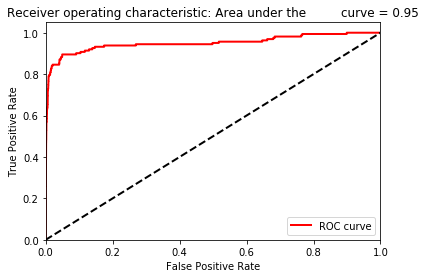

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.3538 - acc: 0.5334 - val_loss: 0.2774 - val_acc: 0.5648
Epoch 2/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2801 - acc: 0.5762 - val_loss: 0.2774 - val_acc: 0.5844
Epoch 3/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2800 - acc: 0.5692 - val_loss: 0.2752 - val_acc: 0.5754
Epoch 4/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2775 - acc: 0.5786 - val_loss: 0.2757 - val_acc: 0.5778
Epoch 5/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2793 - acc: 0.5797 - val_loss: 0.2746 - val_acc: 0.5798
Epoch 6/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2781 - acc: 0.5910 - val_loss: 0.2750 - val_acc: 0.5934
Epoch 7/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2772 - acc: 0.5955 - val

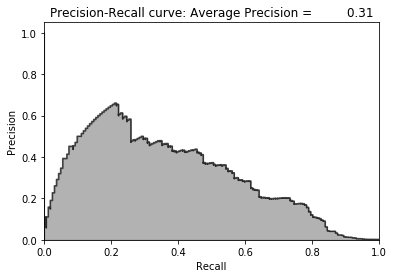

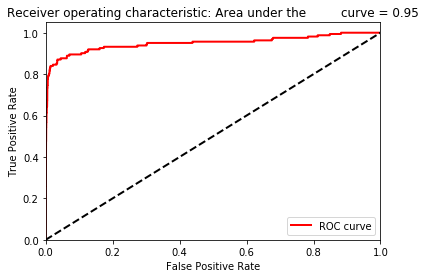

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.3436 - acc: 0.5685 - val_loss: 0.2828 - val_acc: 0.5942
Epoch 2/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2813 - acc: 0.5927 - val_loss: 0.2769 - val_acc: 0.5811
Epoch 3/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2806 - acc: 0.5879 - val_loss: 0.2765 - val_acc: 0.6158
Epoch 4/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2815 - acc: 0.6402 - val_loss: 0.2762 - val_acc: 0.6352
Epoch 5/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2793 - acc: 0.6268 - val_loss: 0.2752 - val_acc: 0.6192
Epoch 6/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2785 - acc: 0.6164 - val_loss: 0.2746 - val_acc: 0.6127
Epoch 7/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2785 - acc: 0.6148 - val

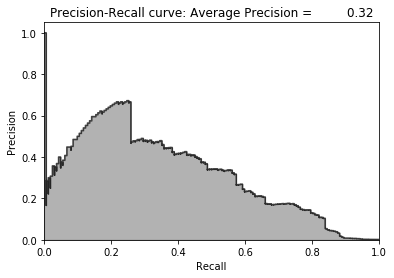

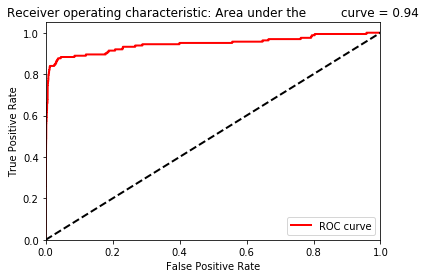

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.3391 - acc: 0.5398 - val_loss: 0.2784 - val_acc: 0.5749
Epoch 2/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2813 - acc: 0.5659 - val_loss: 0.2765 - val_acc: 0.5772
Epoch 3/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.2797 - acc: 0.5815 - val_loss: 0.2753 - val_acc: 0.5880
Epoch 4/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2784 - acc: 0.5835 - val_loss: 0.2750 - val_acc: 0.5873
Epoch 5/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2789 - acc: 0.5856 - val_loss: 0.2808 - val_acc: 0.5807
Epoch 6/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2782 - acc: 0.5861 - val_loss: 0.2741 - val_acc: 0.5751
Epoch 7/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2775 - acc: 0.5667 - val

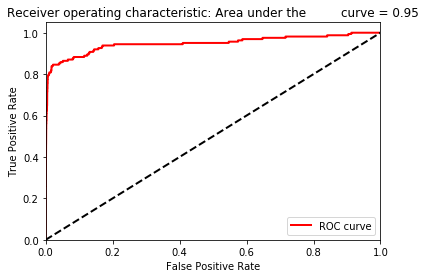

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.3384 - acc: 0.5425 - val_loss: 0.2792 - val_acc: 0.5625
Epoch 2/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2822 - acc: 0.5835 - val_loss: 0.2766 - val_acc: 0.5872
Epoch 3/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2796 - acc: 0.5806 - val_loss: 0.2756 - val_acc: 0.5975
Epoch 4/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2793 - acc: 0.5986 - val_loss: 0.2757 - val_acc: 0.6004
Epoch 5/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.2775 - acc: 0.6034 - val_loss: 0.2749 - val_acc: 0.5988
Epoch 6/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2783 - acc: 0.6078 - val_loss: 0.2743 - val_acc: 0.5965
Epoch 7/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.2783 - acc: 0.5970 - val

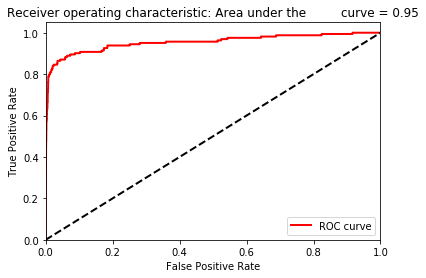

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.3440 - acc: 0.5413 - val_loss: 0.2787 - val_acc: 0.5722
Epoch 2/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2821 - acc: 0.5827 - val_loss: 0.2763 - val_acc: 0.5880
Epoch 3/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2806 - acc: 0.5942 - val_loss: 0.2754 - val_acc: 0.5874
Epoch 4/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2790 - acc: 0.5855 - val_loss: 0.2756 - val_acc: 0.5847
Epoch 5/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.2789 - acc: 0.5905 - val_loss: 0.2756 - val_acc: 0.5881
Epoch 6/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2781 - acc: 0.5847 - val_loss: 0.2758 - val_acc: 0.5869
Epoch 7/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.2781 - acc: 0.5866 - val

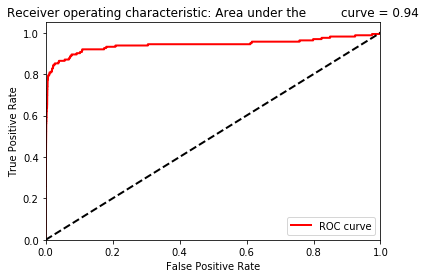

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.3438 - acc: 0.5247 - val_loss: 0.2782 - val_acc: 0.5531
Epoch 2/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2811 - acc: 0.5681 - val_loss: 0.2764 - val_acc: 0.5760
Epoch 3/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2802 - acc: 0.6047 - val_loss: 0.2761 - val_acc: 0.5997
Epoch 4/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.2788 - acc: 0.6050 - val_loss: 0.2762 - val_acc: 0.5919
Epoch 5/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2785 - acc: 0.6021 - val_loss: 0.2758 - val_acc: 0.5922
Epoch 6/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2779 - acc: 0.5900 - val_loss: 0.2764 - val_acc: 0.5888
Epoch 7/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.2783 - acc: 0.5867 - val

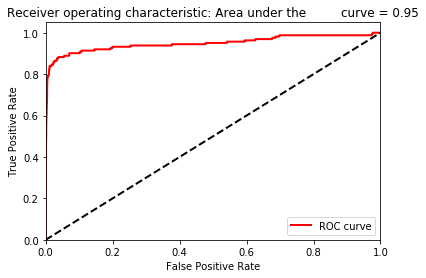

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.3454 - acc: 0.5338 - val_loss: 0.2789 - val_acc: 0.5812
Epoch 2/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2813 - acc: 0.5854 - val_loss: 0.2758 - val_acc: 0.5979
Epoch 3/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2796 - acc: 0.6036 - val_loss: 0.2769 - val_acc: 0.5948
Epoch 4/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2781 - acc: 0.5926 - val_loss: 0.2750 - val_acc: 0.6008
Epoch 5/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2782 - acc: 0.6014 - val_loss: 0.2744 - val_acc: 0.5928
Epoch 6/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.2768 - acc: 0.5901 - val_loss: 0.2772 - val_acc: 0.5943
Epoch 7/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2775 - acc: 0.5933 - val

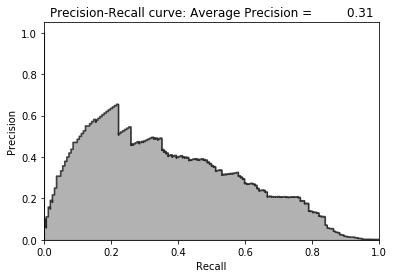

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 71us/step - loss: 0.3571 - acc: 0.5340 - val_loss: 0.2784 - val_acc: 0.5616
Epoch 2/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2817 - acc: 0.5629 - val_loss: 0.2812 - val_acc: 0.5675
Epoch 3/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2798 - acc: 0.5818 - val_loss: 0.2781 - val_acc: 0.5841
Epoch 4/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2797 - acc: 0.5998 - val_loss: 0.2759 - val_acc: 0.5952
Epoch 5/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.2791 - acc: 0.5969 - val_loss: 0.2755 - val_acc: 0.6054
Epoch 6/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2787 - acc: 0.6122 - val_loss: 0.2756 - val_acc: 0.6197
Epoch 7/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2784 - acc: 0.6155 - val

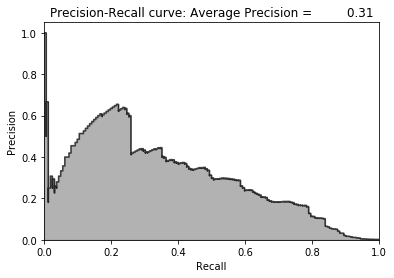

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.3393 - acc: 0.5592 - val_loss: 0.2777 - val_acc: 0.5938
Epoch 2/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.2814 - acc: 0.6072 - val_loss: 0.2771 - val_acc: 0.6186
Epoch 3/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.2786 - acc: 0.6243 - val_loss: 0.2769 - val_acc: 0.6258
Epoch 4/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.2795 - acc: 0.6311 - val_loss: 0.2755 - val_acc: 0.6252
Epoch 5/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.2789 - acc: 0.6237 - val_loss: 0.2750 - val_acc: 0.6242
Epoch 6/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.2783 - acc: 0.6183 - val_loss: 0.2751 - val_acc: 0.6240
Epoch 7/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.2780 - acc: 0.6281 - val

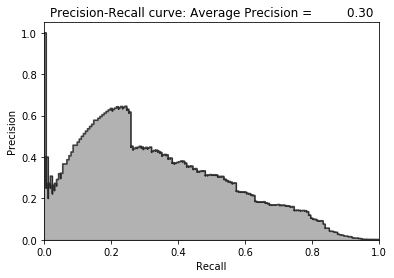

Mean average precision over 10 runs:  0.311563140038849


[0.3058357313136178,
 0.3140891929142319,
 0.3207864228329668,
 0.31642686374557105,
 0.3051246515407359,
 0.3172142713416082,
 0.32580036448365035,
 0.30912420034441657,
 0.3050371435555575,
 0.2961925583161336]

In [22]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 입력층에 선형 활성화 함수 적용
    # 20개 노드를 가진 은닉층 생성
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # 은닉층에 선형 활성화 함수 적용
    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [23]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.311563140038849
Coefficient of variation over 10 runs:  0.027021678866371166


[0.3058357313136178,
 0.3140891929142319,
 0.3207864228329668,
 0.31642686374557105,
 0.3051246515407359,
 0.3172142713416082,
 0.32580036448365035,
 0.30912420034441657,
 0.3050371435555575,
 0.2961925583161336]

In [24]:
# 모델 2 v2
# 선형 활성화 함수를 가진 2-계층 과소완전 오토인코더(은닉층 27개 노드)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.1308 - acc: 0.7816 - val_loss: 0.0372 - val_acc: 0.8640
Epoch 2/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0429 - acc: 0.9047 - val_loss: 0.0383 - val_acc: 0.9246
Epoch 3/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0398 - acc: 0.9300 - val_loss: 0.0374 - val_acc: 0.9374
Epoch 4/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0387 - acc: 0.9381 - val_loss: 0.0367 - val_acc: 0.9522
Epoch 5/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0394 - acc: 0.9519 - val_loss: 0.0367 - val_acc: 0.9577
Epoch 6/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0386 - acc: 0.9521 - val_loss: 0.0384 - val_acc: 0.9606
Epoch 7/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0389 - acc: 0.9589 - val

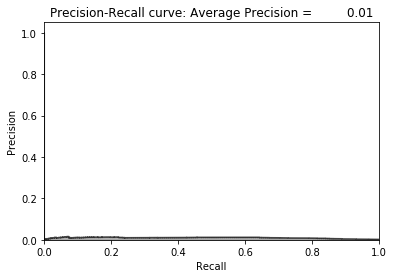

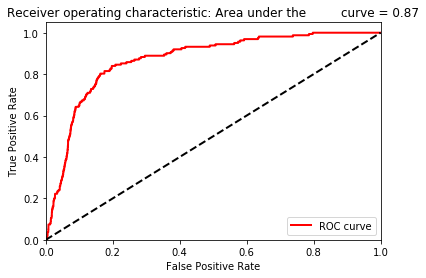

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.1126 - acc: 0.8009 - val_loss: 0.0366 - val_acc: 0.8688
Epoch 2/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0380 - acc: 0.8471 - val_loss: 0.0381 - val_acc: 0.9246
Epoch 3/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0416 - acc: 0.9474 - val_loss: 0.0373 - val_acc: 0.9361
Epoch 4/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0390 - acc: 0.9416 - val_loss: 0.0372 - val_acc: 0.9491
Epoch 5/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0387 - acc: 0.9490 - val_loss: 0.0371 - val_acc: 0.9524
Epoch 6/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0392 - acc: 0.9555 - val_loss: 0.0366 - val_acc: 0.9445
Epoch 7/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0386 - acc: 0.9432 - val

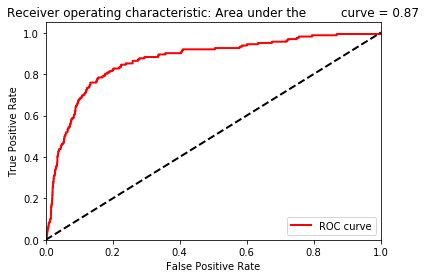

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.1156 - acc: 0.7882 - val_loss: 0.0370 - val_acc: 0.8713
Epoch 2/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0392 - acc: 0.8943 - val_loss: 0.0379 - val_acc: 0.8997
Epoch 3/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0393 - acc: 0.9056 - val_loss: 0.0357 - val_acc: 0.9165
Epoch 4/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0382 - acc: 0.9209 - val_loss: 0.0357 - val_acc: 0.9246
Epoch 5/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0400 - acc: 0.9371 - val_loss: 0.0359 - val_acc: 0.9423
Epoch 6/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0393 - acc: 0.9471 - val_loss: 0.0366 - val_acc: 0.9376
Epoch 7/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0381 - acc: 0.9403 - val

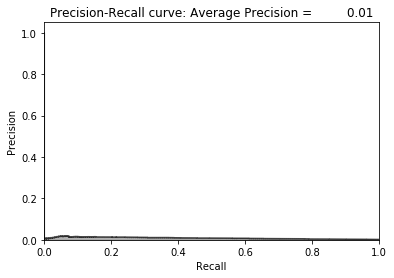

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.1166 - acc: 0.8276 - val_loss: 0.0380 - val_acc: 0.9329
Epoch 2/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0391 - acc: 0.9363 - val_loss: 0.0374 - val_acc: 0.9490
Epoch 3/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0387 - acc: 0.9521 - val_loss: 0.0366 - val_acc: 0.9481
Epoch 4/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0395 - acc: 0.9528 - val_loss: 0.0368 - val_acc: 0.9582
Epoch 5/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0393 - acc: 0.9516 - val_loss: 0.0369 - val_acc: 0.9461
Epoch 6/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0390 - acc: 0.9495 - val_loss: 0.0380 - val_acc: 0.9545
Epoch 7/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0389 - acc: 0.9570 - val

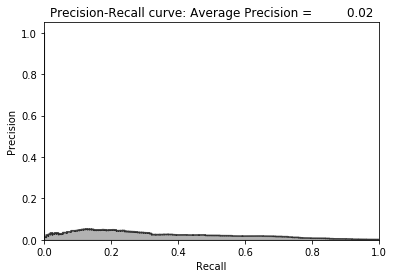

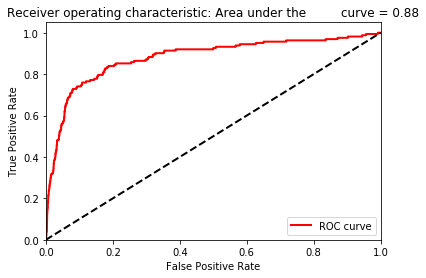

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.1189 - acc: 0.8120 - val_loss: 0.0355 - val_acc: 0.8834
Epoch 2/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0378 - acc: 0.8937 - val_loss: 0.0346 - val_acc: 0.9064
Epoch 3/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0358 - acc: 0.9062 - val_loss: 0.0339 - val_acc: 0.9592
Epoch 4/10
190820/190820 [==============================] - 13s 71us/step - loss: 0.0358 - acc: 0.9462 - val_loss: 0.0352 - val_acc: 0.9471
Epoch 5/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0371 - acc: 0.9605 - val_loss: 0.0341 - val_acc: 0.9507
Epoch 6/10
190820/190820 [==============================] - 13s 71us/step - loss: 0.0357 - acc: 0.9542 - val_loss: 0.0339 - val_acc: 0.9631
Epoch 7/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0352 - acc: 0.9634 - val

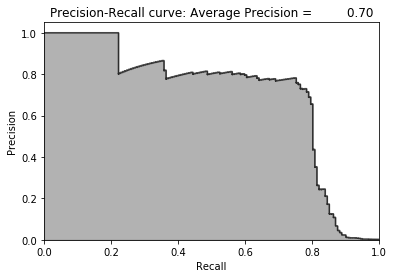

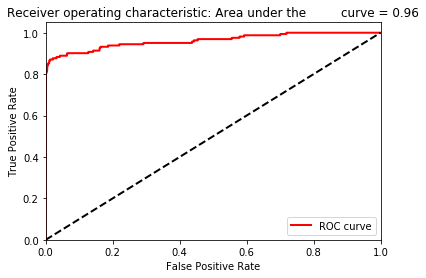

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.1229 - acc: 0.8284 - val_loss: 0.0362 - val_acc: 0.9272
Epoch 2/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0407 - acc: 0.9378 - val_loss: 0.0365 - val_acc: 0.9394
Epoch 3/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0387 - acc: 0.9493 - val_loss: 0.0372 - val_acc: 0.9430
Epoch 4/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0390 - acc: 0.9469 - val_loss: 0.0368 - val_acc: 0.9568
Epoch 5/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0393 - acc: 0.9546 - val_loss: 0.0372 - val_acc: 0.9464
Epoch 6/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0389 - acc: 0.9535 - val_loss: 0.0365 - val_acc: 0.9576
Epoch 7/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0385 - acc: 0.9544 - val

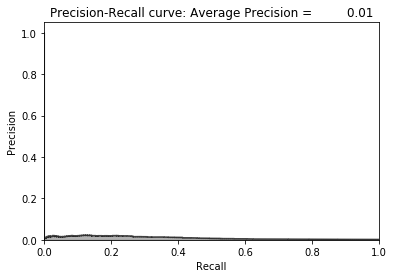

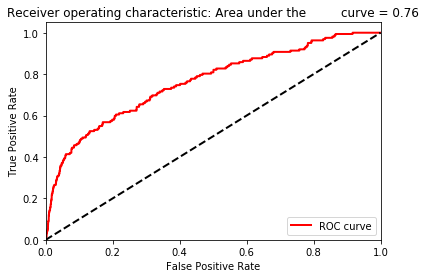

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.1164 - acc: 0.8192 - val_loss: 0.0383 - val_acc: 0.9140
Epoch 2/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0405 - acc: 0.9411 - val_loss: 0.0369 - val_acc: 0.9551
Epoch 3/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0386 - acc: 0.9517 - val_loss: 0.0366 - val_acc: 0.9571
Epoch 4/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0388 - acc: 0.9557 - val_loss: 0.0375 - val_acc: 0.9579
Epoch 5/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0388 - acc: 0.9571 - val_loss: 0.0377 - val_acc: 0.9593
Epoch 6/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0390 - acc: 0.9568 - val_loss: 0.0373 - val_acc: 0.9574
Epoch 7/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0393 - acc: 0.9603 - val

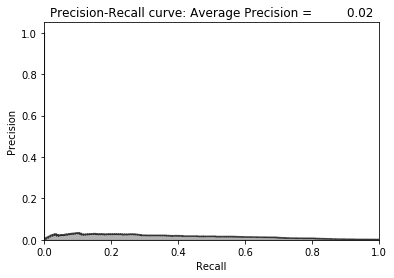

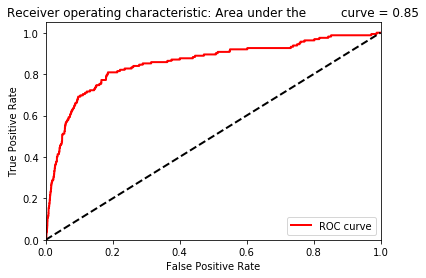

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.1650 - acc: 0.7678 - val_loss: 0.0363 - val_acc: 0.9255
Epoch 2/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0398 - acc: 0.9357 - val_loss: 0.0360 - val_acc: 0.9370
Epoch 3/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0372 - acc: 0.9493 - val_loss: 0.0346 - val_acc: 0.9227
Epoch 4/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0358 - acc: 0.9500 - val_loss: 0.0343 - val_acc: 0.9507
Epoch 5/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0358 - acc: 0.9572 - val_loss: 0.0351 - val_acc: 0.9202
Epoch 6/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0360 - acc: 0.9230 - val_loss: 0.0343 - val_acc: 0.9527
Epoch 7/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0358 - acc: 0.9610 - val

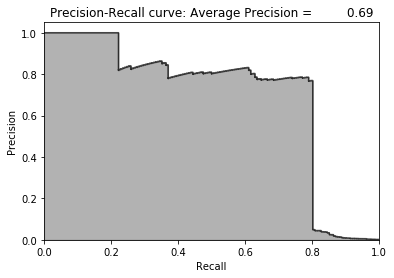

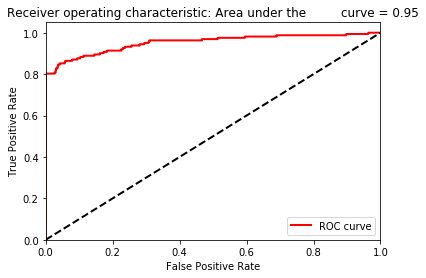

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.1117 - acc: 0.8513 - val_loss: 0.0353 - val_acc: 0.9346
Epoch 2/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0378 - acc: 0.9381 - val_loss: 0.0346 - val_acc: 0.9431
Epoch 3/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0367 - acc: 0.9421 - val_loss: 0.0341 - val_acc: 0.9527
Epoch 4/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.0354 - acc: 0.9568 - val_loss: 0.0346 - val_acc: 0.9274
Epoch 5/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0356 - acc: 0.9469 - val_loss: 0.0348 - val_acc: 0.9564
Epoch 6/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0352 - acc: 0.9574 - val_loss: 0.0339 - val_acc: 0.9655
Epoch 7/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0354 - acc: 0.9572 - val

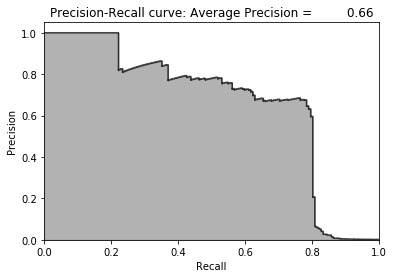

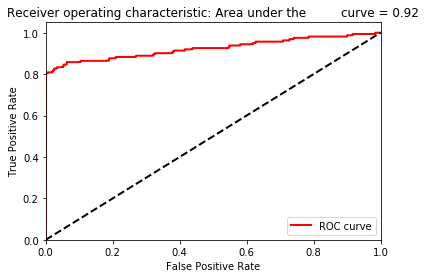

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.1108 - acc: 0.8221 - val_loss: 0.0365 - val_acc: 0.8777
Epoch 2/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0408 - acc: 0.9294 - val_loss: 0.0365 - val_acc: 0.9508
Epoch 3/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0387 - acc: 0.9564 - val_loss: 0.0362 - val_acc: 0.9617
Epoch 4/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0392 - acc: 0.9593 - val_loss: 0.0364 - val_acc: 0.9657
Epoch 5/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0389 - acc: 0.9596 - val_loss: 0.0367 - val_acc: 0.9631
Epoch 6/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0386 - acc: 0.9573 - val_loss: 0.0368 - val_acc: 0.9640
Epoch 7/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0386 - acc: 0.9605 - val

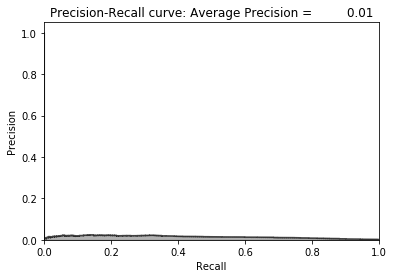

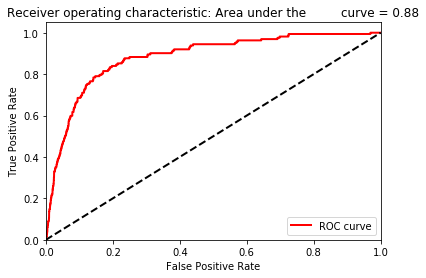

Mean average precision over 10 runs:  0.2156778011187955


[0.009896621934802164,
 0.012928726505254132,
 0.00860997985773044,
 0.02339919446643833,
 0.7026063503753995,
 0.009612707330127188,
 0.016096137075521166,
 0.6948368037932112,
 0.6644730204265519,
 0.014318469422919238]

In [25]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 입력층에 선형 활성화 함수 적용
    # 27개 노드를 가진 은닉층 생성
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # 은닉층에 선형 활성화 함수 적용
    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [26]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.2156778011187955
Coefficient of variation over 10 runs:  1.4322742331027754


[0.009896621934802164,
 0.012928726505254132,
 0.00860997985773044,
 0.02339919446643833,
 0.7026063503753995,
 0.009612707330127188,
 0.016096137075521166,
 0.6948368037932112,
 0.6644730204265519,
 0.014318469422919238]

In [27]:
# 모델 3
# 선형 활성화 함수로 구성된 3-계층 과소완전 오토인코더(2개 은닉층에 각각 28개 노드, 27개 노드)
# 2개 은닉층에 각각 28개 노드, 27개 노드

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.1157 - acc: 0.8091 - val_loss: 0.0403 - val_acc: 0.9137
Epoch 2/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0416 - acc: 0.9449 - val_loss: 0.0381 - val_acc: 0.9395
Epoch 3/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0397 - acc: 0.9425 - val_loss: 0.0407 - val_acc: 0.9418
Epoch 4/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0397 - acc: 0.9490 - val_loss: 0.0371 - val_acc: 0.9476
Epoch 5/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0391 - acc: 0.9434 - val_loss: 0.0376 - val_acc: 0.9477
Epoch 6/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0392 - acc: 0.9472 - val_loss: 0.0369 - val_acc: 0.9549
Epoch 7/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0395 - acc: 0.9543 - val

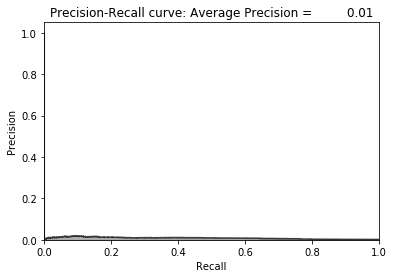

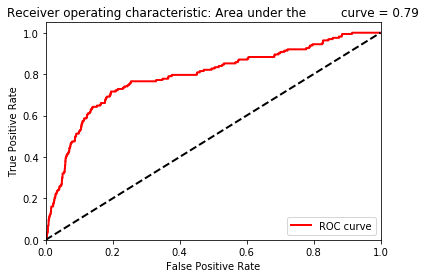

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.1320 - acc: 0.7705 - val_loss: 0.0391 - val_acc: 0.8787
Epoch 2/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0402 - acc: 0.8786 - val_loss: 0.0361 - val_acc: 0.8923
Epoch 3/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0382 - acc: 0.8999 - val_loss: 0.0397 - val_acc: 0.8948
Epoch 4/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0399 - acc: 0.9052 - val_loss: 0.0448 - val_acc: 0.9037
Epoch 5/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0414 - acc: 0.9223 - val_loss: 0.0361 - val_acc: 0.9235
Epoch 6/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0408 - acc: 0.9321 - val_loss: 0.0372 - val_acc: 0.9483
Epoch 7/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0394 - acc: 0.9535 - val

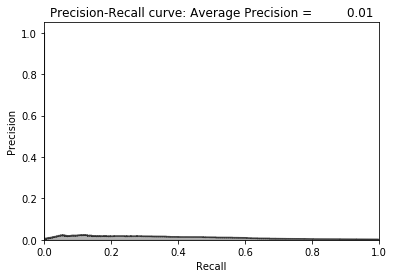

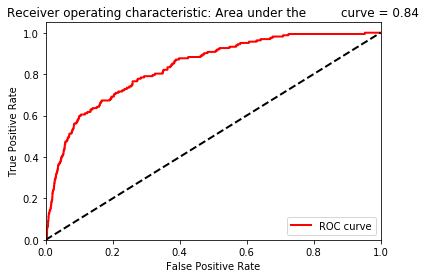

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.1340 - acc: 0.7866 - val_loss: 0.0379 - val_acc: 0.9078
Epoch 2/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0408 - acc: 0.9359 - val_loss: 0.0363 - val_acc: 0.9515
Epoch 3/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0395 - acc: 0.9545 - val_loss: 0.0377 - val_acc: 0.9598
Epoch 4/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0392 - acc: 0.9587 - val_loss: 0.0368 - val_acc: 0.9656
Epoch 5/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0397 - acc: 0.9626 - val_loss: 0.0369 - val_acc: 0.9661
Epoch 6/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0395 - acc: 0.9584 - val_loss: 0.0392 - val_acc: 0.9514
Epoch 7/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0390 - acc: 0.9601 - val

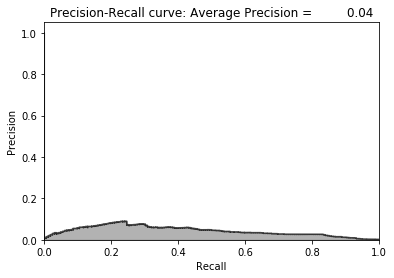

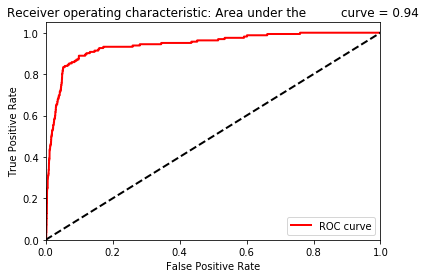

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.1135 - acc: 0.7848 - val_loss: 0.0379 - val_acc: 0.8704
Epoch 2/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0382 - acc: 0.8886 - val_loss: 0.0347 - val_acc: 0.9083
Epoch 3/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0364 - acc: 0.9216 - val_loss: 0.0359 - val_acc: 0.9343
Epoch 4/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0363 - acc: 0.9510 - val_loss: 0.0361 - val_acc: 0.9396
Epoch 5/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0364 - acc: 0.9496 - val_loss: 0.0346 - val_acc: 0.9553
Epoch 6/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0361 - acc: 0.9563 - val_loss: 0.0340 - val_acc: 0.9611
Epoch 7/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0357 - acc: 0.9576 - val

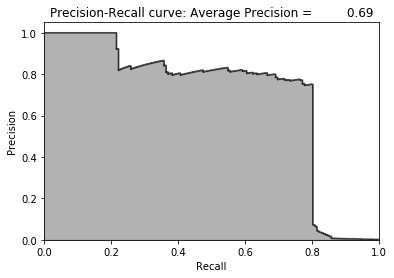

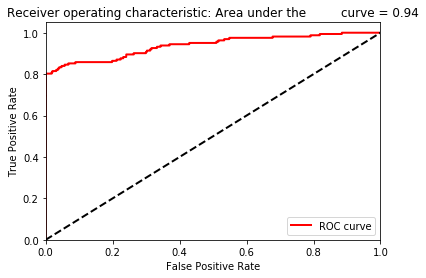

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.1286 - acc: 0.7730 - val_loss: 0.0370 - val_acc: 0.8473
Epoch 2/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0417 - acc: 0.8826 - val_loss: 0.0362 - val_acc: 0.9126
Epoch 3/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0395 - acc: 0.9051 - val_loss: 0.0378 - val_acc: 0.9225
Epoch 4/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0397 - acc: 0.9329 - val_loss: 0.0382 - val_acc: 0.9330
Epoch 5/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0393 - acc: 0.9323 - val_loss: 0.0365 - val_acc: 0.9453
Epoch 6/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0396 - acc: 0.9473 - val_loss: 0.0382 - val_acc: 0.9502
Epoch 7/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0388 - acc: 0.9521 - val

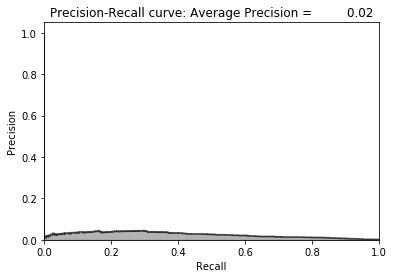

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.1352 - acc: 0.7486 - val_loss: 0.0379 - val_acc: 0.8563
Epoch 2/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0380 - acc: 0.8885 - val_loss: 0.0369 - val_acc: 0.9078
Epoch 3/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0379 - acc: 0.9224 - val_loss: 0.0353 - val_acc: 0.9243
Epoch 4/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0366 - acc: 0.9269 - val_loss: 0.0344 - val_acc: 0.9381
Epoch 5/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0370 - acc: 0.9381 - val_loss: 0.0342 - val_acc: 0.9697
Epoch 6/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0358 - acc: 0.9552 - val_loss: 0.0340 - val_acc: 0.9670
Epoch 7/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0373 - acc: 0.9606 - val

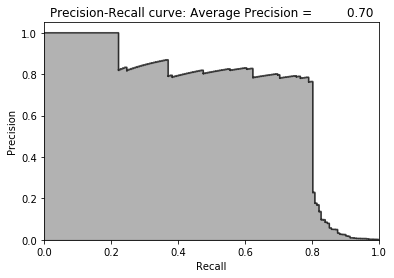

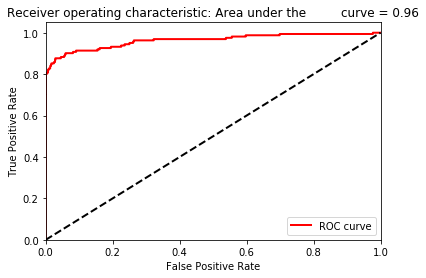

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1222 - acc: 0.7786 - val_loss: 0.0365 - val_acc: 0.8729
Epoch 2/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0392 - acc: 0.8687 - val_loss: 0.0362 - val_acc: 0.8783
Epoch 3/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0381 - acc: 0.8742 - val_loss: 0.0358 - val_acc: 0.8877
Epoch 4/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0370 - acc: 0.9001 - val_loss: 0.0408 - val_acc: 0.9152
Epoch 5/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0366 - acc: 0.9196 - val_loss: 0.0368 - val_acc: 0.9125
Epoch 6/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0357 - acc: 0.9404 - val_loss: 0.0347 - val_acc: 0.9592
Epoch 7/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0360 - acc: 0.9569 - val

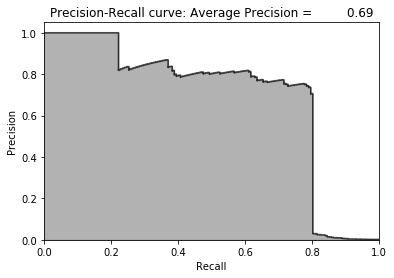

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1303 - acc: 0.7610 - val_loss: 0.0367 - val_acc: 0.8899
Epoch 2/10
190820/190820 [==============================] - 16s 81us/step - loss: 0.0401 - acc: 0.9192 - val_loss: 0.0374 - val_acc: 0.9360
Epoch 3/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0393 - acc: 0.9281 - val_loss: 0.0394 - val_acc: 0.9129
Epoch 4/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0381 - acc: 0.9177 - val_loss: 0.0350 - val_acc: 0.9342
Epoch 5/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0365 - acc: 0.9493 - val_loss: 0.0344 - val_acc: 0.9458
Epoch 6/10
190820/190820 [==============================] - 16s 81us/step - loss: 0.0357 - acc: 0.9533 - val_loss: 0.0372 - val_acc: 0.9496
Epoch 7/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0360 - acc: 0.9567 - val

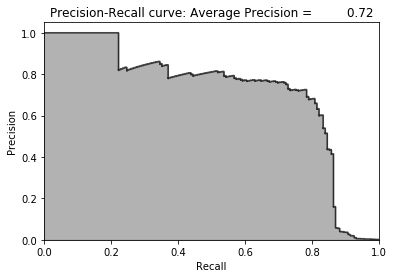

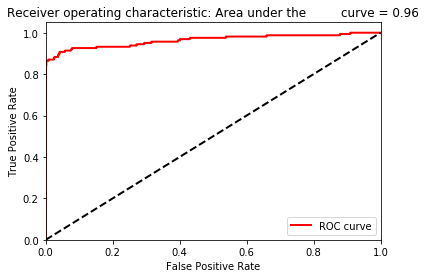

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.1065 - acc: 0.8033 - val_loss: 0.0351 - val_acc: 0.9049
Epoch 2/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.0363 - acc: 0.9404 - val_loss: 0.0358 - val_acc: 0.9190
Epoch 3/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0403 - acc: 0.9321 - val_loss: 0.0353 - val_acc: 0.9284
Epoch 4/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0374 - acc: 0.9306 - val_loss: 0.0376 - val_acc: 0.9472
Epoch 5/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0397 - acc: 0.9507 - val_loss: 0.0361 - val_acc: 0.9287
Epoch 6/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0392 - acc: 0.9379 - val_loss: 0.0359 - val_acc: 0.9400
Epoch 7/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.0401 - acc: 0.9426 - val

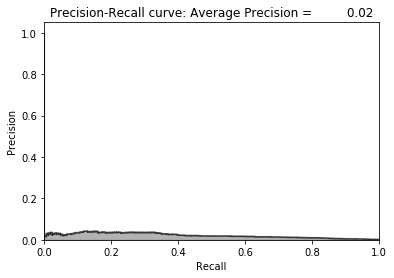

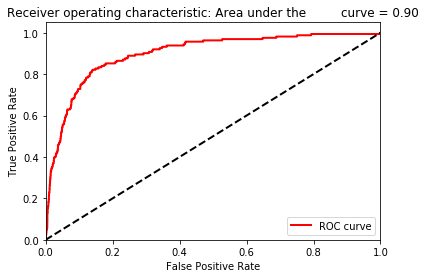

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.1242 - acc: 0.7981 - val_loss: 0.0379 - val_acc: 0.9294
Epoch 2/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0392 - acc: 0.9297 - val_loss: 0.0389 - val_acc: 0.9441
Epoch 3/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0403 - acc: 0.9505 - val_loss: 0.0387 - val_acc: 0.9543
Epoch 4/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.0390 - acc: 0.9568 - val_loss: 0.0383 - val_acc: 0.9566
Epoch 5/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0393 - acc: 0.9579 - val_loss: 0.0368 - val_acc: 0.9607
Epoch 6/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0387 - acc: 0.9601 - val_loss: 0.0426 - val_acc: 0.9490
Epoch 7/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.0387 - acc: 0.9605 - val

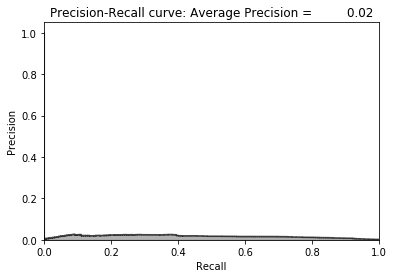

Mean average precision over 10 runs:  0.29312482495755793


[0.008699916681654376,
 0.01140001616331239,
 0.04278585509318021,
 0.6948122749418456,
 0.024384143819748252,
 0.7033976622584848,
 0.6894276256058686,
 0.7184138495382303,
 0.0211251191020685,
 0.01680178637118623]

In [28]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 입력층에 선형 활성화 함수 적용
    # 27개 노드를 가진 첫번째 은닉층 생성
    # 28개 노드를 가진 두번째 은닉층 생성
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # 두번째 은닉층에 선형 활성화 함수 적용
    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [29]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.29312482495755793
Coefficient of variation over 10 runs:  1.13818881116254


[0.008699916681654376,
 0.01140001616331239,
 0.04278585509318021,
 0.6948122749418456,
 0.024384143819748252,
 0.7033976622584848,
 0.6894276256058686,
 0.7184138495382303,
 0.0211251191020685,
 0.01680178637118623]

In [30]:
# 모델 4
# ReLu 활성화 함수를 가진 4-계층 과소완전 오토인코더(4개의 은닉층에 각각 27개 노드,22개 노드,27개 노드,29개 노드)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.6840 - acc: 0.6303 - val_loss: 0.6171 - val_acc: 0.7546
Epoch 2/10
190820/190820 [==============================] - 17s 92us/step - loss: 0.5938 - acc: 0.7789 - val_loss: 0.5818 - val_acc: 0.8101
Epoch 3/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.5799 - acc: 0.8095 - val_loss: 0.5750 - val_acc: 0.8210
Epoch 4/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.5738 - acc: 0.8290 - val_loss: 0.5691 - val_acc: 0.8443
Epoch 5/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.5599 - acc: 0.8612 - val_loss: 0.5430 - val_acc: 0.8872
Epoch 6/10
190820/190820 [==============================] - 18s 97us/step - loss: 0.5479 - acc: 0.8858 - val_loss: 0.5411 - val_acc: 0.8937
Epoch 7/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.5434 - acc: 0.8882 - val

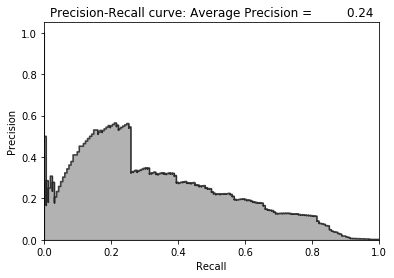

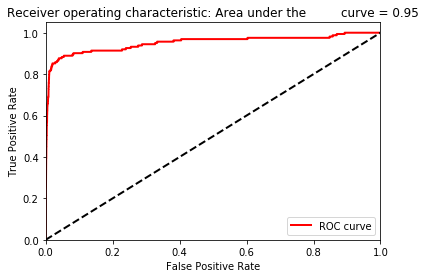

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.6727 - acc: 0.6632 - val_loss: 0.6100 - val_acc: 0.7983
Epoch 2/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.6068 - acc: 0.8109 - val_loss: 0.6057 - val_acc: 0.8240
Epoch 3/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.6013 - acc: 0.8334 - val_loss: 0.5933 - val_acc: 0.8556
Epoch 4/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.6012 - acc: 0.8440 - val_loss: 0.5932 - val_acc: 0.8516
Epoch 5/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.5982 - acc: 0.8466 - val_loss: 0.5923 - val_acc: 0.8651
Epoch 6/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.5968 - acc: 0.8500 - val_loss: 0.5916 - val_acc: 0.8624
Epoch 7/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.5923 - acc: 0.8586 - va

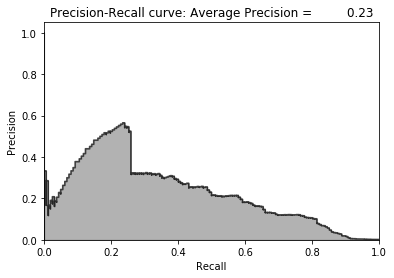

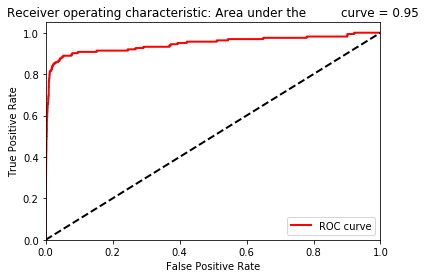

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 111us/step - loss: 0.6698 - acc: 0.6731 - val_loss: 0.6045 - val_acc: 0.8254
Epoch 2/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.5999 - acc: 0.8317 - val_loss: 0.5913 - val_acc: 0.8669
Epoch 3/10
190820/190820 [==============================] - 18s 95us/step - loss: 0.5936 - acc: 0.8530 - val_loss: 0.5908 - val_acc: 0.8464
Epoch 4/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.5925 - acc: 0.8616 - val_loss: 0.5896 - val_acc: 0.8623
Epoch 5/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.5904 - acc: 0.8627 - val_loss: 0.5886 - val_acc: 0.8630
Epoch 6/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.5894 - acc: 0.8641 - val_loss: 0.5881 - val_acc: 0.8702
Epoch 7/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.5920 - acc: 0.8610 - va

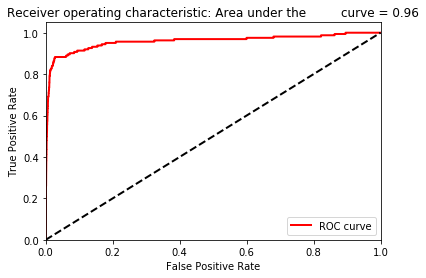

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.6668 - acc: 0.6360 - val_loss: 0.5790 - val_acc: 0.7746
Epoch 2/10
190820/190820 [==============================] - 19s 97us/step - loss: 0.5606 - acc: 0.8303 - val_loss: 0.5472 - val_acc: 0.8789
Epoch 3/10
190820/190820 [==============================] - 19s 97us/step - loss: 0.5488 - acc: 0.8739 - val_loss: 0.5408 - val_acc: 0.8960
Epoch 4/10
190820/190820 [==============================] - 18s 95us/step - loss: 0.5435 - acc: 0.8852 - val_loss: 0.5437 - val_acc: 0.8755
Epoch 5/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.5403 - acc: 0.8945 - val_loss: 0.5369 - val_acc: 0.9088
Epoch 6/10
190820/190820 [==============================] - 18s 96us/step - loss: 0.5426 - acc: 0.8932 - val_loss: 0.5365 - val_acc: 0.9208
Epoch 7/10
190820/190820 [==============================] - 18s 96us/step - loss: 0.5390 - acc: 0.8991 - va

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.6697 - acc: 0.6152 - val_loss: 0.6101 - val_acc: 0.7396
Epoch 2/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.6034 - acc: 0.7530 - val_loss: 0.5954 - val_acc: 0.7680
Epoch 3/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.5928 - acc: 0.7667 - val_loss: 0.5851 - val_acc: 0.7856
Epoch 4/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.5857 - acc: 0.7788 - val_loss: 0.5820 - val_acc: 0.7664
Epoch 5/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.5800 - acc: 0.7822 - val_loss: 0.5862 - val_acc: 0.7534
Epoch 6/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.5801 - acc: 0.7868 - val_loss: 0.5758 - val_acc: 0.7898
Epoch 7/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.5772 - acc: 0.7860 - va

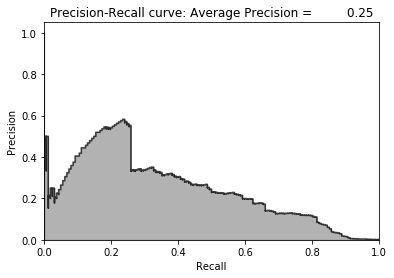

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.6670 - acc: 0.6413 - val_loss: 0.6226 - val_acc: 0.7283
Epoch 2/10
190820/190820 [==============================] - 18s 97us/step - loss: 0.5877 - acc: 0.7979 - val_loss: 0.5792 - val_acc: 0.8159
Epoch 3/10
190820/190820 [==============================] - 18s 96us/step - loss: 0.5777 - acc: 0.8160 - val_loss: 0.5733 - val_acc: 0.8180
Epoch 4/10
190820/190820 [==============================] - 18s 96us/step - loss: 0.5750 - acc: 0.8210 - val_loss: 0.5682 - val_acc: 0.8411
Epoch 5/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.5705 - acc: 0.8274 - val_loss: 0.5712 - val_acc: 0.8061
Epoch 6/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.5681 - acc: 0.8316 - val_loss: 0.5650 - val_acc: 0.8393
Epoch 7/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.5663 - acc: 0.8371 - va

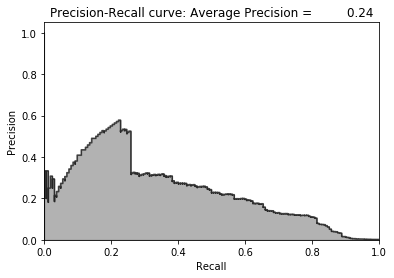

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.6811 - acc: 0.6474 - val_loss: 0.6184 - val_acc: 0.7869
Epoch 2/10
190820/190820 [==============================] - 19s 100us/step - loss: 0.6105 - acc: 0.8169 - val_loss: 0.6003 - val_acc: 0.8290
Epoch 3/10
190820/190820 [==============================] - 19s 100us/step - loss: 0.5974 - acc: 0.8498 - val_loss: 0.5946 - val_acc: 0.8532
Epoch 4/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.5949 - acc: 0.8561 - val_loss: 0.5931 - val_acc: 0.8555
Epoch 5/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.5932 - acc: 0.8632 - val_loss: 0.5907 - val_acc: 0.8680
Epoch 6/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.5910 - acc: 0.8726 - val_loss: 0.5900 - val_acc: 0.8830
Epoch 7/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.5908 - acc: 0.8717 - 

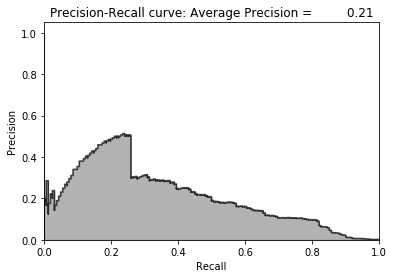

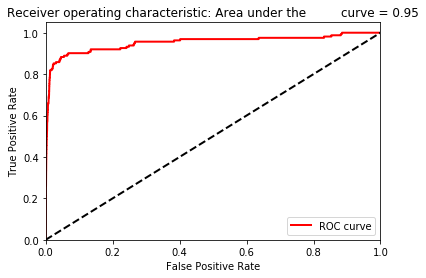

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 112us/step - loss: 0.6858 - acc: 0.6155 - val_loss: 0.6158 - val_acc: 0.7635
Epoch 2/10
190820/190820 [==============================] - 19s 102us/step - loss: 0.6049 - acc: 0.7935 - val_loss: 0.5909 - val_acc: 0.8144
Epoch 3/10
190820/190820 [==============================] - 20s 102us/step - loss: 0.5892 - acc: 0.8258 - val_loss: 0.5847 - val_acc: 0.8473
Epoch 4/10
190820/190820 [==============================] - 19s 102us/step - loss: 0.5861 - acc: 0.8377 - val_loss: 0.5815 - val_acc: 0.8566
Epoch 5/10
190820/190820 [==============================] - 20s 102us/step - loss: 0.5819 - acc: 0.8429 - val_loss: 0.5777 - val_acc: 0.8586
Epoch 6/10
190820/190820 [==============================] - 19s 102us/step - loss: 0.5824 - acc: 0.8392 - val_loss: 0.5768 - val_acc: 0.8677
Epoch 7/10
190820/190820 [==============================] - 20s 102us/step - loss: 0.5794 - acc: 0.848

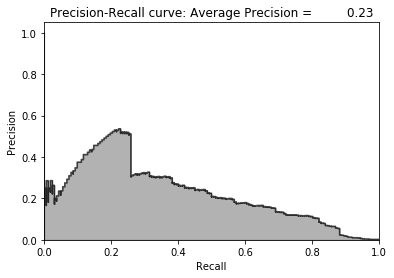

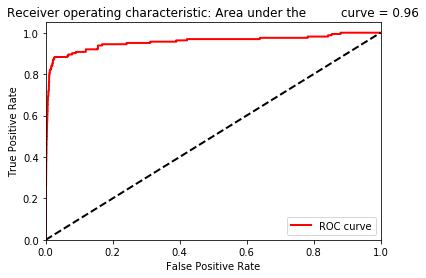

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 113us/step - loss: 0.6769 - acc: 0.6211 - val_loss: 0.6185 - val_acc: 0.7531
Epoch 2/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.6127 - acc: 0.7687 - val_loss: 0.6045 - val_acc: 0.7911
Epoch 3/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.6034 - acc: 0.7838 - val_loss: 0.6007 - val_acc: 0.7768
Epoch 4/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.6013 - acc: 0.7821 - val_loss: 0.5867 - val_acc: 0.8188
Epoch 5/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.5879 - acc: 0.8095 - val_loss: 0.5852 - val_acc: 0.8252
Epoch 6/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.5890 - acc: 0.8071 - val_loss: 0.5849 - val_acc: 0.8230
Epoch 7/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.5878 - acc: 0.814

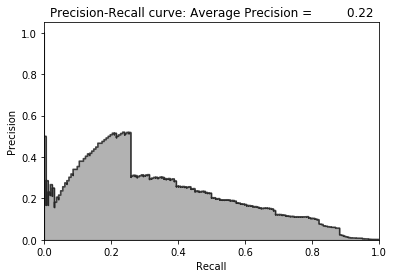

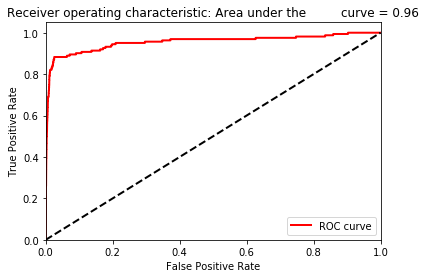

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.6707 - acc: 0.6656 - val_loss: 0.5895 - val_acc: 0.8163
Epoch 2/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.5822 - acc: 0.8390 - val_loss: 0.5705 - val_acc: 0.8576
Epoch 3/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.5750 - acc: 0.8640 - val_loss: 0.5688 - val_acc: 0.8409
Epoch 4/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.5678 - acc: 0.8724 - val_loss: 0.5782 - val_acc: 0.8712
Epoch 5/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.5641 - acc: 0.8896 - val_loss: 0.5638 - val_acc: 0.8830
Epoch 6/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.5622 - acc: 0.8922 - val_loss: 0.5592 - val_acc: 0.9006
Epoch 7/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.5634 - acc: 0.894

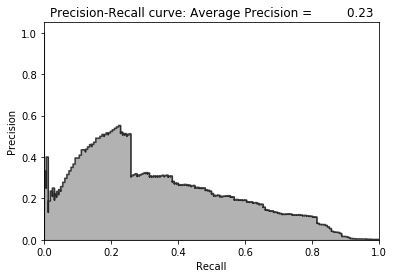

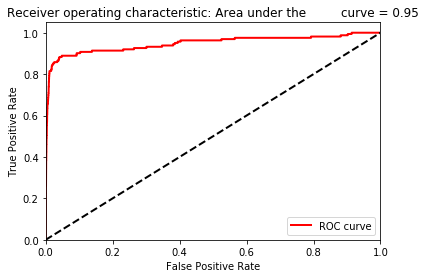

Mean average precision over 10 runs:  0.23155740421473228


[0.2449739496509555,
 0.22990813014718006,
 0.21603592146306574,
 0.25123542760359463,
 0.24591542170525196,
 0.2378654461382492,
 0.2097839545087953,
 0.2261193183541975,
 0.22167190027424502,
 0.23206457230178792]

In [31]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 전체적으로 ReLu 활성화 함수 적용
    # 27개 노드를 가진 첫번째 은닉층 생성
    # 22개 노드를 가진 두번째 은닉층 생성
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # 전체적으로 ReLu 활성화 함수 적용
    # 27개 노드를 가진 세번째 은닉층 생성
    # 29개 노드를 가진 네번째 은닉층 생성
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 훈련 모델
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [32]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.23155740421473228
Coefficient of variation over 10 runs:  0.05561499319001309


[0.2449739496509555,
 0.22990813014718006,
 0.21603592146306574,
 0.25123542760359463,
 0.24591542170525196,
 0.2378654461382492,
 0.2097839545087953,
 0.2261193183541975,
 0.22167190027424502,
 0.23206457230178792]

In [33]:
# 모델 5
# 선형 활성화 함수를 가진 2-계층 과대완전 오토인코더(은닉층 40개 노드)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0407 - acc: 0.9433 - val_loss: 1.4707e-04 - val_acc: 0.9938
Epoch 2/10
190820/190820 [==============================] - 19s 99us/step - loss: 9.2545e-04 - acc: 0.9922 - val_loss: 2.6908e-08 - val_acc: 0.9999
Epoch 3/10
190820/190820 [==============================] - 19s 100us/step - loss: 9.0234e-04 - acc: 0.9927 - val_loss: 4.0696e-05 - val_acc: 0.9991
Epoch 4/10
190820/190820 [==============================] - 19s 100us/step - loss: 0.0010 - acc: 0.9926 - val_loss: 1.5209e-06 - val_acc: 0.9993
Epoch 5/10
190820/190820 [==============================] - 19s 101us/step - loss: 7.9346e-04 - acc: 0.9940 - val_loss: 8.9843e-04 - val_acc: 0.9879
Epoch 6/10
190820/190820 [==============================] - 19s 100us/step - loss: 8.3873e-04 - acc: 0.9933 - val_loss: 0.0014 - val_acc: 0.9777
Epoch 7/10
190820/190820 [==============================] - 19s 100

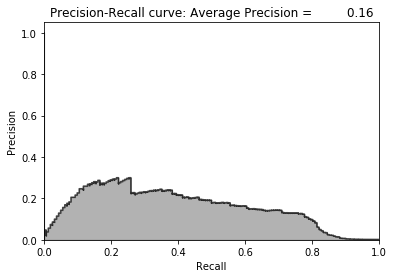

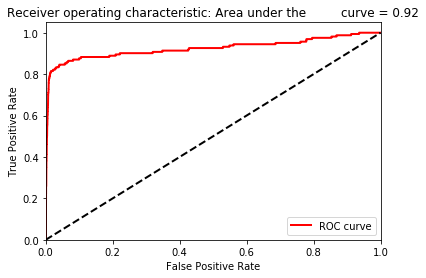

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 112us/step - loss: 0.0560 - acc: 0.9326 - val_loss: 0.0020 - val_acc: 0.9930
Epoch 2/10
190820/190820 [==============================] - 20s 102us/step - loss: 9.2357e-04 - acc: 0.9923 - val_loss: 2.4869e-05 - val_acc: 0.9982
Epoch 3/10
190820/190820 [==============================] - 20s 103us/step - loss: 8.1054e-04 - acc: 0.9930 - val_loss: 1.2562e-06 - val_acc: 0.9997
Epoch 4/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0011 - acc: 0.9935 - val_loss: 2.9569e-04 - val_acc: 0.9939
Epoch 5/10
190820/190820 [==============================] - 19s 101us/step - loss: 7.1133e-04 - acc: 0.9938 - val_loss: 0.0122 - val_acc: 0.9657
Epoch 6/10
190820/190820 [==============================] - 20s 103us/step - loss: 8.3559e-04 - acc: 0.9930 - val_loss: 9.0764e-05 - val_acc: 0.9950
Epoch 7/10
190820/190820 [==============================] - 20s 104us/

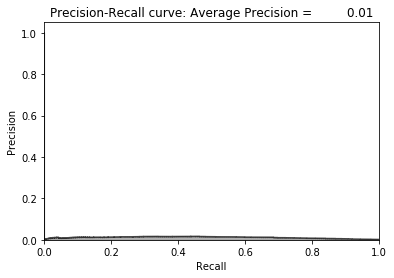

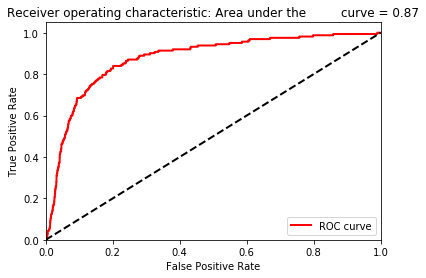

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0606 - acc: 0.9268 - val_loss: 5.1054e-06 - val_acc: 0.9990
Epoch 2/10
190820/190820 [==============================] - 18s 95us/step - loss: 0.0011 - acc: 0.9919 - val_loss: 2.0274e-05 - val_acc: 0.9980
Epoch 3/10
190820/190820 [==============================] - 18s 96us/step - loss: 9.5295e-04 - acc: 0.9941 - val_loss: 1.5298e-05 - val_acc: 0.9982
Epoch 4/10
190820/190820 [==============================] - 18s 96us/step - loss: 7.9451e-04 - acc: 0.9931 - val_loss: 6.0351e-05 - val_acc: 0.9976
Epoch 5/10
190820/190820 [==============================] - 19s 99us/step - loss: 8.1016e-04 - acc: 0.9931 - val_loss: 0.0028 - val_acc: 0.9754
Epoch 6/10
190820/190820 [==============================] - 22s 115us/step - loss: 7.4442e-04 - acc: 0.9937 - val_loss: 2.0313e-04 - val_acc: 0.9920
Epoch 7/10
190820/190820 [==============================] - 22s 116us/

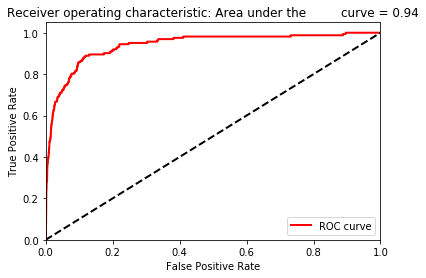

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0516 - acc: 0.9373 - val_loss: 1.0366e-05 - val_acc: 0.9986
Epoch 2/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0012 - acc: 0.9931 - val_loss: 3.1493e-04 - val_acc: 0.9971
Epoch 3/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.0012 - acc: 0.9920 - val_loss: 0.0015 - val_acc: 0.9829
Epoch 4/10
190820/190820 [==============================] - 21s 111us/step - loss: 8.2763e-04 - acc: 0.9922 - val_loss: 1.7945e-09 - val_acc: 1.0000
Epoch 5/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0013 - acc: 0.9936 - val_loss: 1.5001e-04 - val_acc: 0.9987
Epoch 6/10
190820/190820 [==============================] - 19s 100us/step - loss: 0.0011 - acc: 0.9930 - val_loss: 3.8994e-04 - val_acc: 0.9944
Epoch 7/10
190820/190820 [==============================] - 21s 108us/step - lo

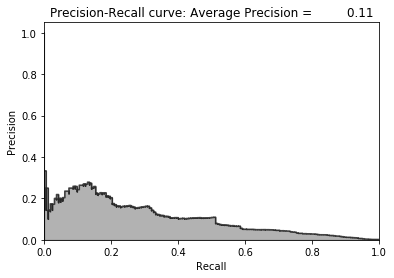

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 118us/step - loss: 0.0650 - acc: 0.9279 - val_loss: 6.3236e-04 - val_acc: 0.9841
Epoch 2/10
190820/190820 [==============================] - 20s 104us/step - loss: 8.5469e-04 - acc: 0.9922 - val_loss: 5.8486e-04 - val_acc: 0.9877
Epoch 3/10
190820/190820 [==============================] - 19s 98us/step - loss: 9.5457e-04 - acc: 0.9937 - val_loss: 2.7324e-05 - val_acc: 0.9984
Epoch 4/10
190820/190820 [==============================] - 19s 99us/step - loss: 7.1662e-04 - acc: 0.9932 - val_loss: 2.9943e-06 - val_acc: 0.9994
Epoch 5/10
190820/190820 [==============================] - 24s 124us/step - loss: 6.9517e-04 - acc: 0.9925 - val_loss: 2.8286e-04 - val_acc: 0.9895
Epoch 6/10
190820/190820 [==============================] - 24s 123us/step - loss: 7.8784e-04 - acc: 0.9942 - val_loss: 4.6892e-05 - val_acc: 0.9977
Epoch 7/10
190820/190820 [==============================] - 

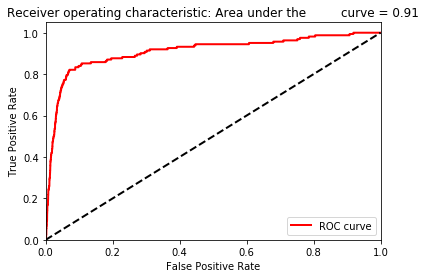

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0545 - acc: 0.9322 - val_loss: 2.0410e-05 - val_acc: 0.9984
Epoch 2/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0011 - acc: 0.9934 - val_loss: 0.0018 - val_acc: 0.9767
Epoch 3/10
190820/190820 [==============================] - 22s 113us/step - loss: 8.4302e-04 - acc: 0.9929 - val_loss: 0.0029 - val_acc: 0.9764
Epoch 4/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0011 - acc: 0.9930 - val_loss: 1.4980e-06 - val_acc: 0.9995
Epoch 5/10
190820/190820 [==============================] - 22s 115us/step - loss: 8.1464e-04 - acc: 0.9953 - val_loss: 6.0343e-05 - val_acc: 0.9964
Epoch 6/10
190820/190820 [==============================] - 22s 117us/step - loss: 8.5979e-04 - acc: 0.9925 - val_loss: 5.6540e-05 - val_acc: 0.9977
Epoch 7/10
190820/190820 [==============================] - 19s 98us/step 

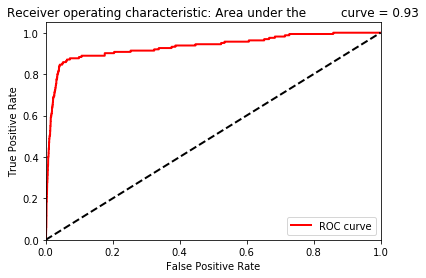

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0608 - acc: 0.9269 - val_loss: 0.0037 - val_acc: 0.9753
Epoch 2/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.0015 - acc: 0.9923 - val_loss: 2.5977e-04 - val_acc: 0.9892
Epoch 3/10
190820/190820 [==============================] - 19s 100us/step - loss: 8.5334e-04 - acc: 0.9934 - val_loss: 0.0061 - val_acc: 0.9689
Epoch 4/10
190820/190820 [==============================] - 19s 99us/step - loss: 8.3765e-04 - acc: 0.9922 - val_loss: 1.3386e-05 - val_acc: 0.9985
Epoch 5/10
190820/190820 [==============================] - 19s 100us/step - loss: 8.9319e-04 - acc: 0.9937 - val_loss: 3.4326e-05 - val_acc: 0.9983
Epoch 6/10
190820/190820 [==============================] - 19s 100us/step - loss: 8.8543e-04 - acc: 0.9930 - val_loss: 5.6780e-06 - val_acc: 0.9983
Epoch 7/10
190820/190820 [==============================] - 19s 99us/ste

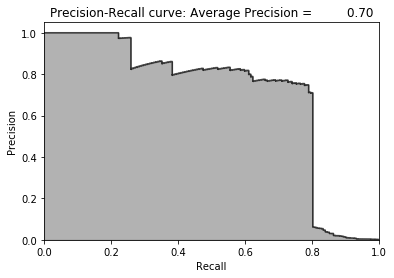

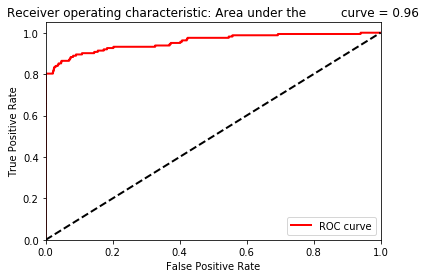

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0757 - acc: 0.9060 - val_loss: 0.0076 - val_acc: 0.9783
Epoch 2/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0011 - acc: 0.9941 - val_loss: 2.6996e-08 - val_acc: 0.9999
Epoch 3/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0010 - acc: 0.9928 - val_loss: 0.0037 - val_acc: 0.9612
Epoch 4/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0011 - acc: 0.9931 - val_loss: 0.0046 - val_acc: 0.9810
Epoch 5/10
190820/190820 [==============================] - 24s 123us/step - loss: 7.8086e-04 - acc: 0.9937 - val_loss: 2.2032e-06 - val_acc: 0.9991
Epoch 6/10
190820/190820 [==============================] - 20s 104us/step - loss: 5.6649e-04 - acc: 0.9934 - val_loss: 3.4819e-04 - val_acc: 0.9889
Epoch 7/10
190820/190820 [==============================] - 19s 98us/step - loss: 

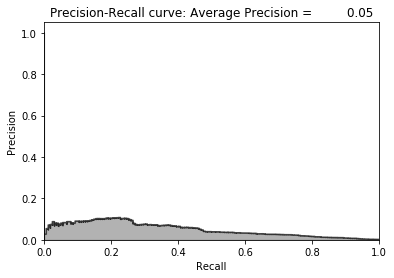

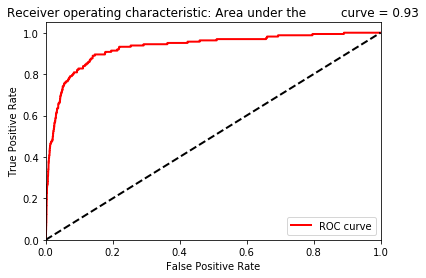

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 118us/step - loss: 0.0579 - acc: 0.9277 - val_loss: 0.0073 - val_acc: 0.9699
Epoch 2/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0012 - acc: 0.9910 - val_loss: 3.3218e-06 - val_acc: 0.9992
Epoch 3/10
190820/190820 [==============================] - 25s 133us/step - loss: 7.3992e-04 - acc: 0.9928 - val_loss: 0.0015 - val_acc: 0.9898
Epoch 4/10
190820/190820 [==============================] - 25s 131us/step - loss: 9.5826e-04 - acc: 0.9931 - val_loss: 1.2614e-05 - val_acc: 0.9990
Epoch 5/10
190820/190820 [==============================] - 21s 110us/step - loss: 6.9955e-04 - acc: 0.9943 - val_loss: 1.0980e-05 - val_acc: 0.9981
Epoch 6/10
190820/190820 [==============================] - 21s 109us/step - loss: 8.0749e-04 - acc: 0.9940 - val_loss: 8.7676e-04 - val_acc: 0.9920
Epoch 7/10
190820/190820 [==============================] - 24s 126us/

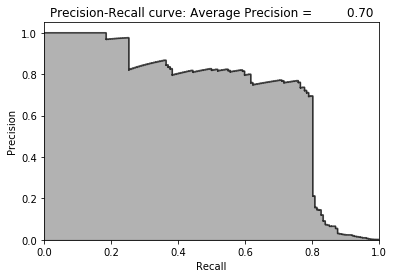

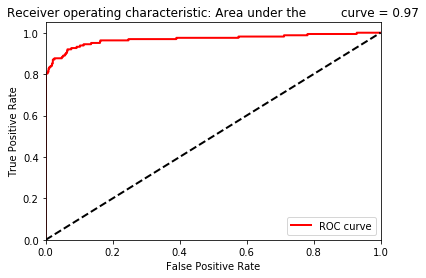

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11998s 63ms/step - loss: 0.0483 - acc: 0.9405 - val_loss: 2.5316e-06 - val_acc: 0.9994
Epoch 2/10
190820/190820 [==============================] - 55s 286us/step - loss: 9.5139e-04 - acc: 0.9922 - val_loss: 0.0057 - val_acc: 0.9762
Epoch 3/10
190820/190820 [==============================] - 62s 327us/step - loss: 0.0010 - acc: 0.9920 - val_loss: 9.8680e-06 - val_acc: 0.9986
Epoch 4/10
190820/190820 [==============================] - 62s 327us/step - loss: 4.5538e-04 - acc: 0.9944 - val_loss: 2.3636e-04 - val_acc: 0.9937
Epoch 5/10
190820/190820 [==============================] - 60s 316us/step - loss: 8.5152e-04 - acc: 0.9922 - val_loss: 5.9186e-05 - val_acc: 0.9975
Epoch 6/10
190820/190820 [==============================] - 62s 326us/step - loss: 5.2491e-04 - acc: 0.9946 - val_loss: 5.5906e-06 - val_acc: 0.9987
Epoch 7/10
190820/190820 [==============================] - 61s 

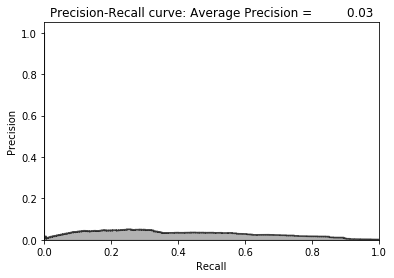

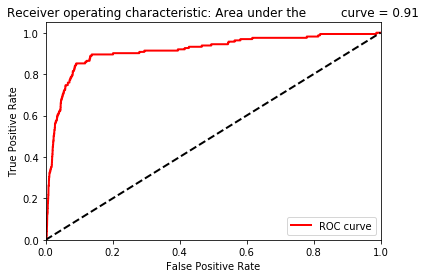

Mean average precision over 10 runs:  0.19162188592801674


[0.15876014145311454,
 0.011433111010940362,
 0.06825053043499435,
 0.10500346053177148,
 0.032216229647330105,
 0.060472801353464285,
 0.7007972557614603,
 0.04958040690052108,
 0.7010923052241687,
 0.0286126169624022]

In [34]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 전체적으로 선형 활성화 함수 적용
    # 40개 노드를 가진 은닉층 생성
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [35]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.19162188592801674
Coefficient of variation over 10 runs:  1.3451963050171385


[0.15876014145311454,
 0.011433111010940362,
 0.06825053043499435,
 0.10500346053177148,
 0.032216229647330105,
 0.060472801353464285,
 0.7007972557614603,
 0.04958040690052108,
 0.7010923052241687,
 0.0286126169624022]

In [36]:
# 모델 6
# 드롭아웃과 선형 활성화 함수를 가진 2-계층 과소완전 오토인코더(은닉층 40개 노드, 드룹아웃 비율: 10%)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 74s 388us/step - loss: 0.1339 - acc: 0.7409 - val_loss: 0.0072 - val_acc: 0.9772
Epoch 2/10
190820/190820 [==============================] - 72s 380us/step - loss: 0.0774 - acc: 0.7850 - val_loss: 0.0077 - val_acc: 0.9757
Epoch 3/10
190820/190820 [==============================] - 64s 337us/step - loss: 0.0782 - acc: 0.7859 - val_loss: 0.0069 - val_acc: 0.9770
Epoch 4/10
190820/190820 [==============================] - 65s 341us/step - loss: 0.0758 - acc: 0.7853 - val_loss: 0.0071 - val_acc: 0.9756
Epoch 5/10
190820/190820 [==============================] - 66s 347us/step - loss: 0.0762 - acc: 0.7859 - val_loss: 0.0159 - val_acc: 0.9503
Epoch 6/10
190820/190820 [==============================] - 66s 347us/step - loss: 0.0760 - acc: 0.7852 - val_loss: 0.0074 - val

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 81s 426us/step - loss: 0.1407 - acc: 0.7396 - val_loss: 0.0079 - val_acc: 0.9748
Epoch 2/10
190820/190820 [==============================] - 75s 392us/step - loss: 0.0766 - acc: 0.7860 - val_loss: 0.0075 - val_acc: 0.9770
Epoch 3/10
190820/190820 [==============================] - 73s 383us/step - loss: 0.0751 - acc: 0.7860 - val_loss: 0.0077 - val_acc: 0.9747
Epoch 4/10
190820/190820 [==============================] - 77s 404us/step - loss: 0.0764 - acc: 0.7839 - val_loss: 0.0097 - val_acc: 0.9664
Epoch 5/10
190820/190820 [==============================] - 55s 286us/step - loss: 0.0775 - acc: 0.7862 - val_loss: 0.0155 - val_acc: 0.9525
Epoch 6/10
190820/190820 [==============================] - 69s 359us/step - loss: 0.0767 - acc: 0.7847 - val_loss: 0.0073 - val_acc: 0.9762
Epoch 7/10
190820/190820 [==============================] - 66s 348us/step - loss: 0.0771 - acc: 0.785

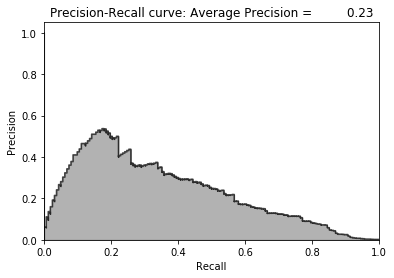

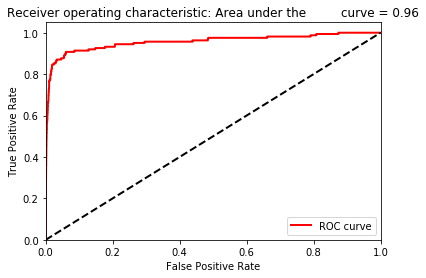

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 67s 350us/step - loss: 0.1273 - acc: 0.7450 - val_loss: 0.0093 - val_acc: 0.9730
Epoch 2/10
190820/190820 [==============================] - 63s 329us/step - loss: 0.0767 - acc: 0.7856 - val_loss: 0.0072 - val_acc: 0.9786
Epoch 3/10
190820/190820 [==============================] - 66s 344us/step - loss: 0.0761 - acc: 0.7845 - val_loss: 0.0082 - val_acc: 0.9705
Epoch 4/10
190820/190820 [==============================] - 65s 342us/step - loss: 0.0760 - acc: 0.7834 - val_loss: 0.0073 - val_acc: 0.9787
Epoch 5/10
190820/190820 [==============================] - 66s 347us/step - loss: 0.0780 - acc: 0.7840 - val_loss: 0.0071 - val_acc: 0.9771
Epoch 6/10
190820/190820 [==============================] - 63s 329us/step - loss: 0.0769 - acc: 0.7838 - val_loss: 0.0088 - val_acc: 0.9697
Epoch 7/10
190820/190820 [==============================] - 72s 378us/step - loss: 0.0782 - acc: 0.784

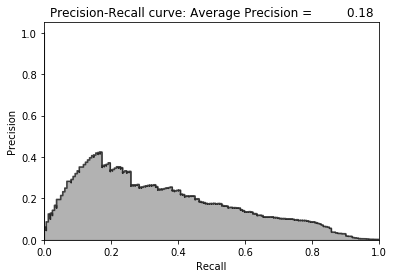

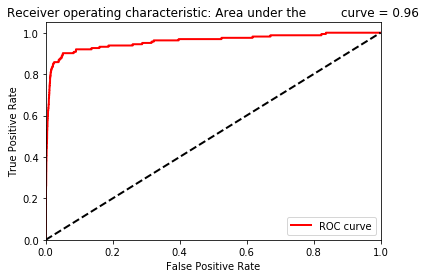

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 72s 375us/step - loss: 0.1418 - acc: 0.7381 - val_loss: 0.0082 - val_acc: 0.9694
Epoch 2/10
190820/190820 [==============================] - 67s 352us/step - loss: 0.0762 - acc: 0.7864 - val_loss: 0.0074 - val_acc: 0.9763
Epoch 3/10
190820/190820 [==============================] - 68s 355us/step - loss: 0.0765 - acc: 0.7858 - val_loss: 0.0070 - val_acc: 0.9784
Epoch 4/10
190820/190820 [==============================] - 68s 354us/step - loss: 0.0774 - acc: 0.7852 - val_loss: 0.0109 - val_acc: 0.9681
Epoch 5/10
190820/190820 [==============================] - 69s 361us/step - loss: 0.0777 - acc: 0.7857 - val_loss: 0.0098 - val_acc: 0.9669
Epoch 6/10
190820/190820 [==============================] - 68s 359us/step - loss: 0.0756 - acc: 0.7879 - val_loss: 0.0079 - val_acc: 0.9747
Epoch 7/10
190820/190820 [==============================] - 68s 359us/step - loss: 0.0755 - acc: 0.788

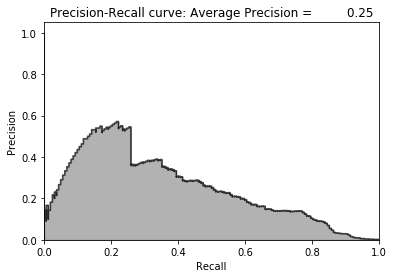

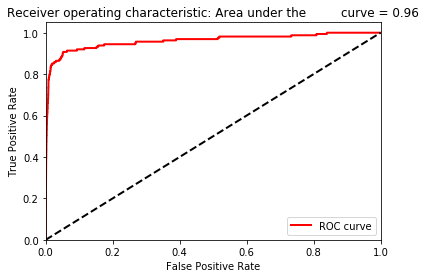

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 75s 391us/step - loss: 0.1447 - acc: 0.7336 - val_loss: 0.0087 - val_acc: 0.9752
Epoch 2/10
190820/190820 [==============================] - 70s 367us/step - loss: 0.0769 - acc: 0.7889 - val_loss: 0.0077 - val_acc: 0.9743
Epoch 3/10
190820/190820 [==============================] - 68s 358us/step - loss: 0.0777 - acc: 0.7867 - val_loss: 0.0069 - val_acc: 0.9760
Epoch 4/10
190820/190820 [==============================] - 68s 357us/step - loss: 0.0753 - acc: 0.7883 - val_loss: 0.0116 - val_acc: 0.9666
Epoch 5/10
190820/190820 [==============================] - 68s 357us/step - loss: 0.0754 - acc: 0.7854 - val_loss: 0.0071 - val_acc: 0.9786
Epoch 6/10
190820/190820 [==============================] - 3844s 20ms/step - loss: 0.0790 - acc: 0.7859 - val_loss: 0.0079 - val_acc: 0.9779
Epoch 7/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0774 - acc: 0.78

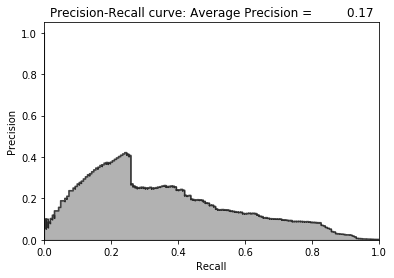

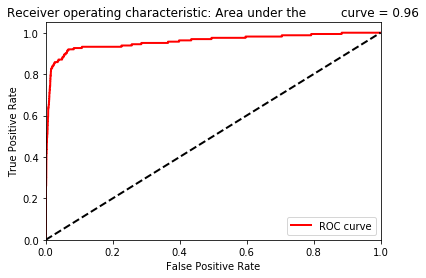

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 149us/step - loss: 0.1348 - acc: 0.7374 - val_loss: 0.0074 - val_acc: 0.9774
Epoch 2/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.0771 - acc: 0.7853 - val_loss: 0.0079 - val_acc: 0.9713
Epoch 3/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0758 - acc: 0.7850 - val_loss: 0.0073 - val_acc: 0.9770
Epoch 4/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0780 - acc: 0.7844 - val_loss: 0.0083 - val_acc: 0.9712
Epoch 5/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.0762 - acc: 0.7840 - val_loss: 0.0069 - val_acc: 0.9769
Epoch 6/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.0756 - acc: 0.7861 - val_loss: 0.0082 - val_acc: 0.9712
Epoch 7/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.0766 - acc: 0.786

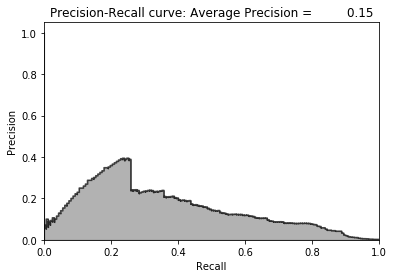

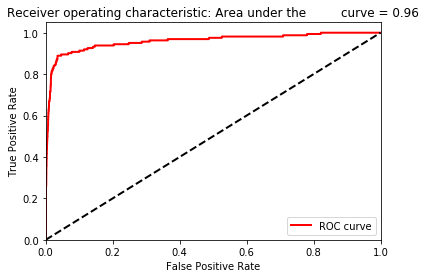

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.1413 - acc: 0.7418 - val_loss: 0.0077 - val_acc: 0.9738
Epoch 2/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0763 - acc: 0.7861 - val_loss: 0.0073 - val_acc: 0.9758
Epoch 3/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0774 - acc: 0.7851 - val_loss: 0.0076 - val_acc: 0.9737
Epoch 4/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.0787 - acc: 0.7875 - val_loss: 0.0099 - val_acc: 0.9661
Epoch 5/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.0758 - acc: 0.7875 - val_loss: 0.0079 - val_acc: 0.9774
Epoch 6/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0766 - acc: 0.7864 - val_loss: 0.0083 - val_acc: 0.9769
Epoch 7/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0778 - acc: 0.785

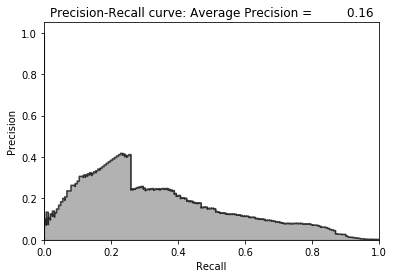

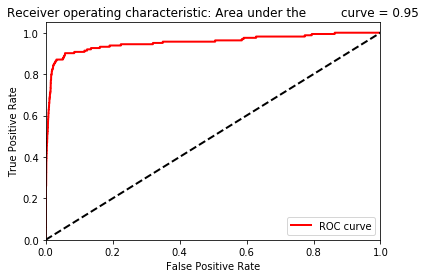

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.1401 - acc: 0.7361 - val_loss: 0.0076 - val_acc: 0.9744
Epoch 2/10
190820/190820 [==============================] - 24s 125us/step - loss: 0.0767 - acc: 0.7833 - val_loss: 0.0083 - val_acc: 0.9751
Epoch 3/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.0749 - acc: 0.7854 - val_loss: 0.0080 - val_acc: 0.9711
Epoch 4/10
190820/190820 [==============================] - 24s 125us/step - loss: 0.0766 - acc: 0.7830 - val_loss: 0.0072 - val_acc: 0.9778
Epoch 5/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.0770 - acc: 0.7847 - val_loss: 0.0075 - val_acc: 0.9772
Epoch 6/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.0798 - acc: 0.7844 - val_loss: 0.0069 - val_acc: 0.9790
Epoch 7/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.0752 - acc: 0.786

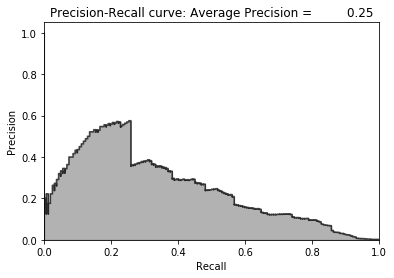

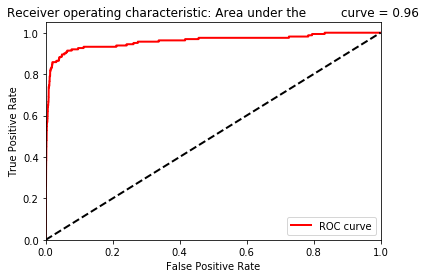

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1493 - acc: 0.7344 - val_loss: 0.0075 - val_acc: 0.9781
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0765 - acc: 0.7862 - val_loss: 0.0111 - val_acc: 0.9662
Epoch 3/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0756 - acc: 0.7849 - val_loss: 0.0067 - val_acc: 0.9746
Epoch 4/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0773 - acc: 0.7867 - val_loss: 0.0073 - val_acc: 0.9790
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0764 - acc: 0.7852 - val_loss: 0.0079 - val_acc: 0.9766
Epoch 6/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.0779 - acc: 0.7836 - val_loss: 0.0067 - val_acc: 0.9817
Epoch 7/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0762 - acc: 0.783

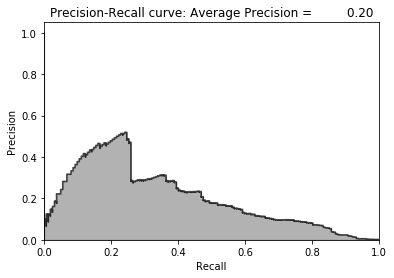

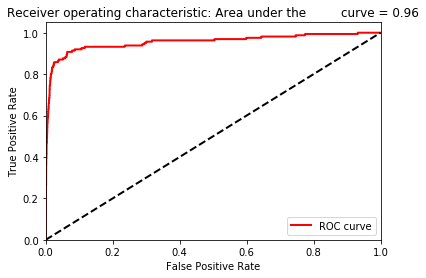

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.1310 - acc: 0.7449 - val_loss: 0.0111 - val_acc: 0.9652
Epoch 2/10
190820/190820 [==============================] - 21s 111us/step - loss: 0.0759 - acc: 0.7857 - val_loss: 0.0073 - val_acc: 0.9770
Epoch 3/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0762 - acc: 0.7879 - val_loss: 0.0078 - val_acc: 0.9763
Epoch 4/10
190820/190820 [==============================] - 21s 110us/step - loss: 0.0768 - acc: 0.7858 - val_loss: 0.0091 - val_acc: 0.9677
Epoch 5/10
190820/190820 [==============================] - 21s 112us/step - loss: 0.0763 - acc: 0.7849 - val_loss: 0.0075 - val_acc: 0.9757
Epoch 6/10
190820/190820 [==============================] - 21s 110us/step - loss: 0.0756 - acc: 0.7858 - val_loss: 0.0072 - val_acc: 0.9782
Epoch 7/10
190820/190820 [==============================] - 21s 110us/step - loss: 0.0757 - acc: 0.785

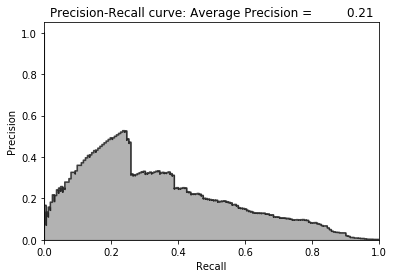

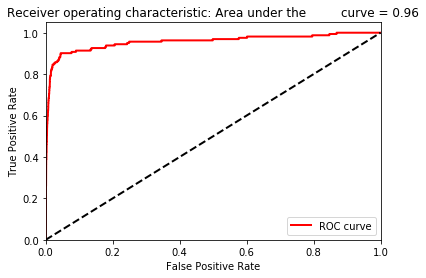

Mean average precision over 10 runs:  0.21010941036853364


[0.28827752761623754,
 0.23304185227242943,
 0.17896791643318913,
 0.2505256269458735,
 0.17143065941231486,
 0.153520269396573,
 0.16462028635842543,
 0.247152461277108,
 0.20278320625699942,
 0.2107742977161863]

In [37]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [38]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.21010941036853364
Coefficient of variation over 10 runs:  0.1987215559002025


[0.28827752761623754,
 0.23304185227242943,
 0.17896791643318913,
 0.2505256269458735,
 0.17143065941231486,
 0.153520269396573,
 0.16462028635842543,
 0.247152461277108,
 0.20278320625699942,
 0.2107742977161863]

In [39]:
# 모델 7
# 선형 활성화 함수를 가진 2-계층 희소 과대완전 오토인코더(은닉층 40개 노드)



Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.1089 - acc: 0.9311 - val_loss: 0.0346 - val_acc: 0.9933
Epoch 2/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0287 - acc: 0.9827 - val_loss: 0.0209 - val_acc: 0.9943
Epoch 3/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0217 - acc: 0.9800 - val_loss: 0.0206 - val_acc: 0.9702
Epoch 4/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.0188 - acc: 0.9831 - val_loss: 0.0144 - val_acc: 0.9915
Epoch 5/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.0184 - acc: 0.9785 - val_loss: 0.0129 - val_acc: 0.9960
Epoch 6/10
190820/190820 [==============================] - 10s 50us/step - loss: 0.0183 - acc: 0.9811 - val_loss: 0.0122 - val_acc: 0.9933
Epoch 7/10
190820/190820 [==============================] - 10s 50us/step - loss: 0.0173 - acc: 0.9749 - va

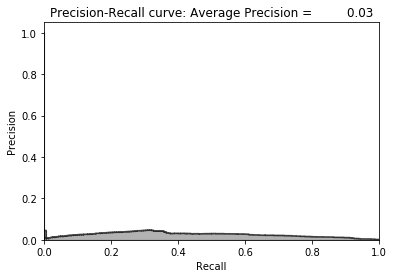

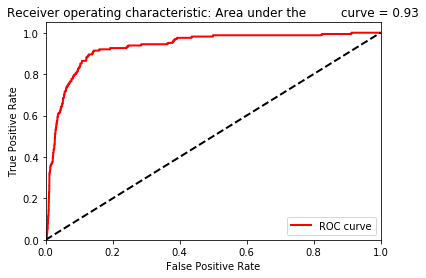

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0969 - acc: 0.9396 - val_loss: 0.0515 - val_acc: 0.9591
Epoch 2/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0307 - acc: 0.9828 - val_loss: 0.0227 - val_acc: 0.9934
Epoch 3/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0230 - acc: 0.9826 - val_loss: 0.0225 - val_acc: 0.9647
Epoch 4/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.0203 - acc: 0.9814 - val_loss: 0.0154 - val_acc: 0.9935
Epoch 5/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0192 - acc: 0.9819 - val_loss: 0.0188 - val_acc: 0.9767
Epoch 6/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.0203 - acc: 0.9786 - val_loss: 0.1065 - val_acc: 0.9046
Epoch 7/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0181 - acc: 0.9807 - val

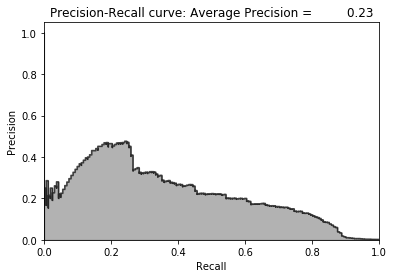

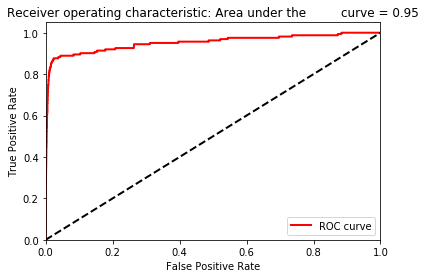

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.1231 - acc: 0.9160 - val_loss: 0.0403 - val_acc: 0.9868
Epoch 2/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.0314 - acc: 0.9845 - val_loss: 0.0233 - val_acc: 0.9945
Epoch 3/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0223 - acc: 0.9837 - val_loss: 0.0203 - val_acc: 0.9611
Epoch 4/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0212 - acc: 0.9816 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 5/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0199 - acc: 0.9790 - val_loss: 0.0174 - val_acc: 0.9780
Epoch 6/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0169 - acc: 0.9814 - val_loss: 0.0126 - val_acc: 0.9905
Epoch 7/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.0168 - acc: 0.9792 - val

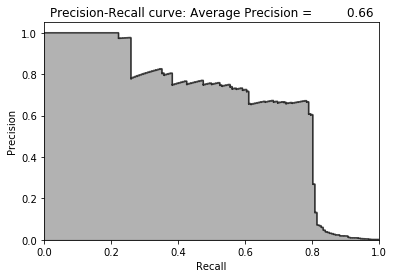

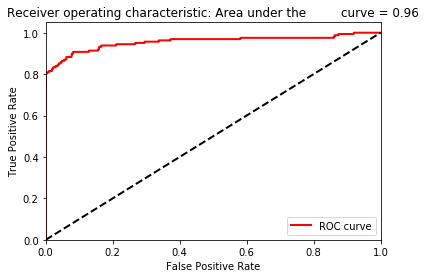

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.1087 - acc: 0.9294 - val_loss: 0.0369 - val_acc: 0.9920
Epoch 2/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0308 - acc: 0.9837 - val_loss: 0.0229 - val_acc: 0.9874
Epoch 3/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.0224 - acc: 0.9833 - val_loss: 0.0176 - val_acc: 0.9906
Epoch 4/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0201 - acc: 0.9805 - val_loss: 0.0149 - val_acc: 0.9944
Epoch 5/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0188 - acc: 0.9818 - val_loss: 0.0152 - val_acc: 0.9861
Epoch 6/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.0175 - acc: 0.9802 - val_loss: 0.0213 - val_acc: 0.9894
Epoch 7/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0174 - acc: 0.9780 - val

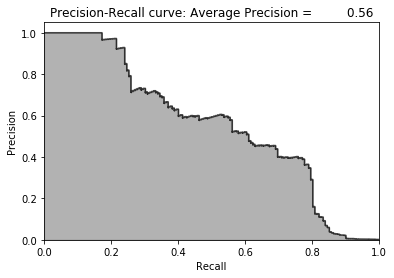

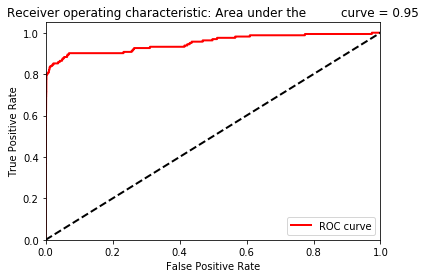

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0988 - acc: 0.9378 - val_loss: 0.0407 - val_acc: 0.9782
Epoch 2/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0298 - acc: 0.9829 - val_loss: 0.0219 - val_acc: 0.9896
Epoch 3/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0231 - acc: 0.9819 - val_loss: 0.0176 - val_acc: 0.9932
Epoch 4/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0203 - acc: 0.9812 - val_loss: 0.0149 - val_acc: 0.9961
Epoch 5/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0184 - acc: 0.9836 - val_loss: 0.0139 - val_acc: 0.9906
Epoch 6/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0176 - acc: 0.9788 - val_loss: 0.0173 - val_acc: 0.9668
Epoch 7/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0179 - acc: 0.9794 - val

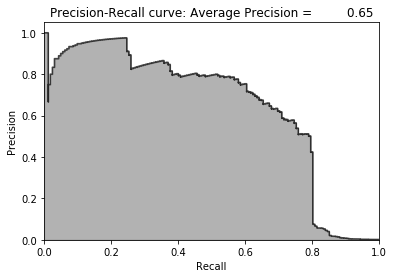

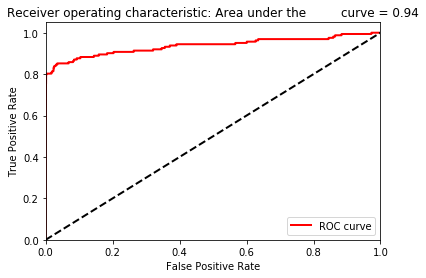

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.1085 - acc: 0.9308 - val_loss: 0.0687 - val_acc: 0.9453
Epoch 2/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0290 - acc: 0.9846 - val_loss: 0.0207 - val_acc: 0.9901
Epoch 3/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0221 - acc: 0.9823 - val_loss: 0.0261 - val_acc: 0.9469
Epoch 4/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0186 - acc: 0.9819 - val_loss: 0.0140 - val_acc: 0.9949
Epoch 5/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0187 - acc: 0.9788 - val_loss: 0.0499 - val_acc: 0.8817
Epoch 6/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.0181 - acc: 0.9806 - val_loss: 0.0170 - val_acc: 0.9880
Epoch 7/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0161 - acc: 0.9811 - val

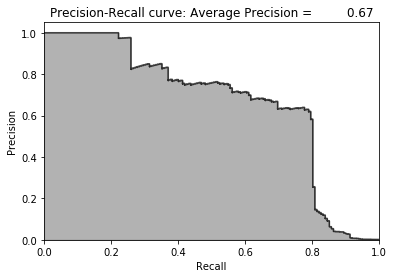

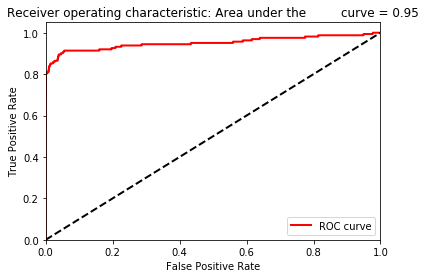

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.1147 - acc: 0.9230 - val_loss: 0.0360 - val_acc: 0.9881
Epoch 2/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0293 - acc: 0.9861 - val_loss: 0.0219 - val_acc: 0.9920
Epoch 3/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.0237 - acc: 0.9806 - val_loss: 0.0178 - val_acc: 0.9931
Epoch 4/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.0197 - acc: 0.9808 - val_loss: 0.0154 - val_acc: 0.9890
Epoch 5/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.0181 - acc: 0.9825 - val_loss: 0.0146 - val_acc: 0.9913
Epoch 6/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0195 - acc: 0.9782 - val_loss: 0.0163 - val_acc: 0.9749
Epoch 7/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0169 - acc: 0.9790 - val

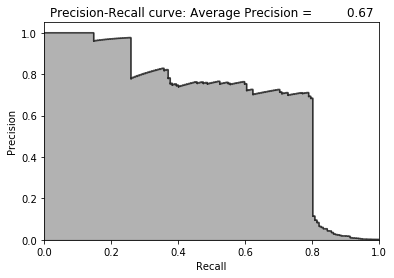

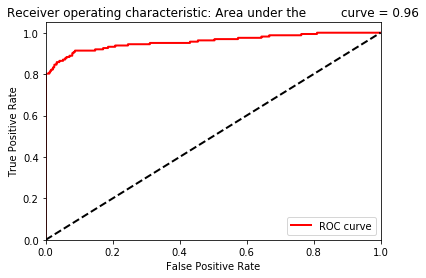

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.0996 - acc: 0.9403 - val_loss: 0.0377 - val_acc: 0.9695
Epoch 2/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0290 - acc: 0.9850 - val_loss: 0.0219 - val_acc: 0.9877
Epoch 3/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0237 - acc: 0.9797 - val_loss: 0.0303 - val_acc: 0.9641
Epoch 4/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.0212 - acc: 0.9811 - val_loss: 0.0156 - val_acc: 0.9935
Epoch 5/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0215 - acc: 0.9770 - val_loss: 0.0139 - val_acc: 0.9937
Epoch 6/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0173 - acc: 0.9809 - val_loss: 0.0133 - val_acc: 0.9893
Epoch 7/10
190820/190820 [==============================] - 18s 97us/step - loss: 0.0176 - acc: 0.9774 - val

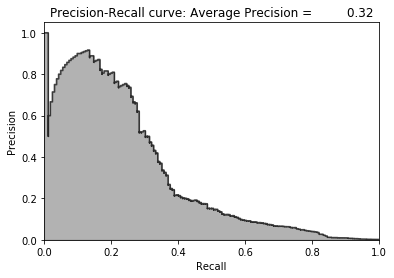

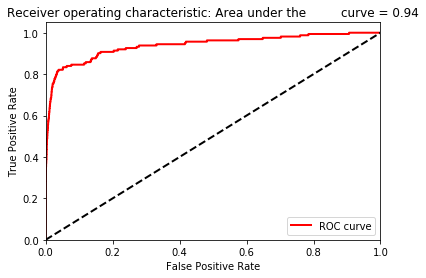

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.1269 - acc: 0.9185 - val_loss: 0.0402 - val_acc: 0.9768
Epoch 2/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.0311 - acc: 0.9841 - val_loss: 0.0339 - val_acc: 0.9569
Epoch 3/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0235 - acc: 0.9814 - val_loss: 0.0332 - val_acc: 0.9588
Epoch 4/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0213 - acc: 0.9809 - val_loss: 0.0154 - val_acc: 0.9840
Epoch 5/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.0175 - acc: 0.9823 - val_loss: 0.0135 - val_acc: 0.9920
Epoch 6/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.0183 - acc: 0.9784 - val_loss: 0.0141 - val_acc: 0.9782
Epoch 7/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0165 - acc: 0.9787 - val

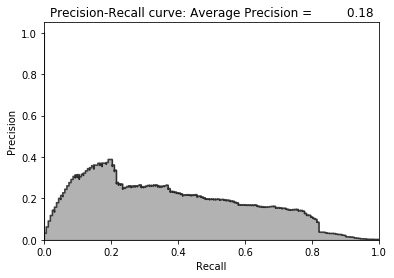

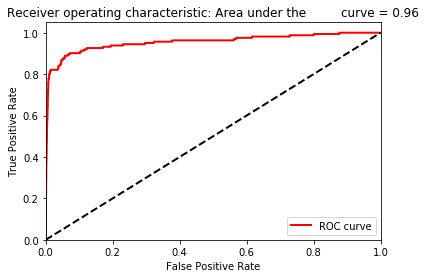

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0980 - acc: 0.9381 - val_loss: 0.0350 - val_acc: 0.9911
Epoch 2/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0285 - acc: 0.9818 - val_loss: 0.0798 - val_acc: 0.9060
Epoch 3/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0224 - acc: 0.9822 - val_loss: 0.0166 - val_acc: 0.9953
Epoch 4/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0193 - acc: 0.9820 - val_loss: 0.0142 - val_acc: 0.9958
Epoch 5/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0185 - acc: 0.9797 - val_loss: 0.0129 - val_acc: 0.9952
Epoch 6/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0211 - acc: 0.9768 - val_loss: 0.0195 - val_acc: 0.9673
Epoch 7/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.0163 - acc: 0.9828 - val

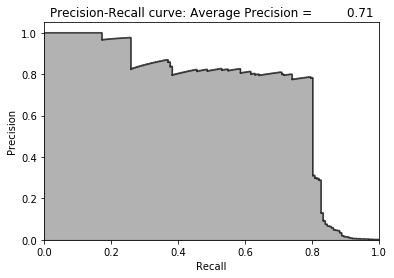

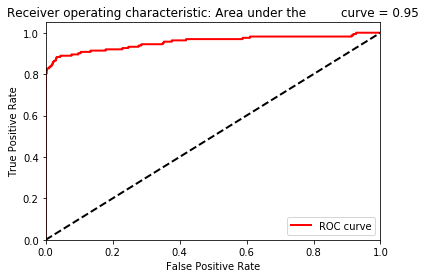

Mean average precision over 10 runs:  0.4672725907455799


[0.025014457888093165,
 0.22604778911371554,
 0.6617700486042288,
 0.5595783764643096,
 0.6465331919283243,
 0.6666075883661268,
 0.6693384515080006,
 0.3218826081046327,
 0.18327981312801614,
 0.7126735823503515]

In [17]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [18]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.4672725907455799
Coefficient of variation over 10 runs:  0.5131024912993515


[0.025014457888093165,
 0.22604778911371554,
 0.6617700486042288,
 0.5595783764643096,
 0.6465331919283243,
 0.6666075883661268,
 0.6693384515080006,
 0.3218826081046327,
 0.18327981312801614,
 0.7126735823503515]

In [19]:
# 모델 8
# 드롭아웃과 선형 활성화 함수를 가진 2-계층 희소 과대완전 오토인코더(은닉층 40개 노드, 드롭아웃 비율: 5%)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.1611 - acc: 0.8096 - val_loss: 0.0475 - val_acc: 0.9802
Epoch 2/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.0773 - acc: 0.8611 - val_loss: 0.0351 - val_acc: 0.9847
Epoch 3/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0685 - acc: 0.8595 - val_loss: 0.0290 - val_acc: 0.9802
Epoch 4/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0653 - acc: 0.8595 - val_loss: 0.0254 - val_acc: 0.9820
Epoch 5/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.0633 - acc: 0.8567 - val_loss: 0.0251 - val_acc: 0.9776
Epoch 6/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0613 - acc: 0.8580 - val_loss: 0.0234 - val_acc: 

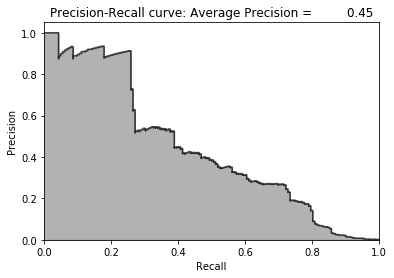

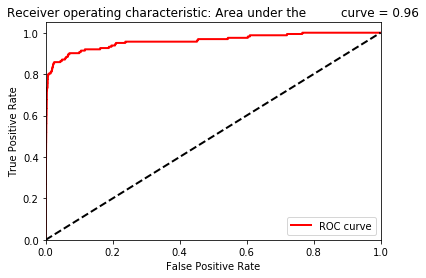

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1592 - acc: 0.8133 - val_loss: 0.0506 - val_acc: 0.9702
Epoch 2/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.0771 - acc: 0.8622 - val_loss: 0.0374 - val_acc: 0.9720
Epoch 3/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.0671 - acc: 0.8630 - val_loss: 0.0282 - val_acc: 0.9816
Epoch 4/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0649 - acc: 0.8611 - val_loss: 0.0261 - val_acc: 0.9786
Epoch 5/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.0637 - acc: 0.8608 - val_loss: 0.0278 - val_acc: 0.9659
Epoch 6/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0618 - acc: 0.8608 - val_loss: 0.0265 - val_acc: 0.9676
Epoch 7/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0602 - acc: 0.8606 - val

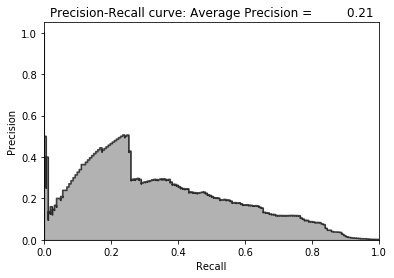

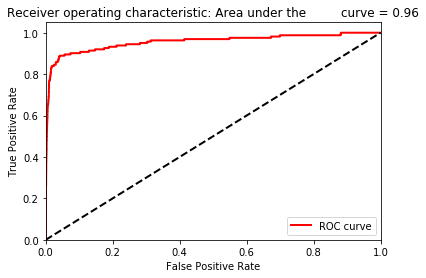

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.1535 - acc: 0.8147 - val_loss: 0.0487 - val_acc: 0.9749
Epoch 2/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0752 - acc: 0.8625 - val_loss: 0.0366 - val_acc: 0.9647
Epoch 3/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0685 - acc: 0.8606 - val_loss: 0.0313 - val_acc: 0.9649
Epoch 4/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0647 - acc: 0.8599 - val_loss: 0.0254 - val_acc: 0.9781
Epoch 5/10
190820/190820 [==============================] - 13s 71us/step - loss: 0.0631 - acc: 0.8591 - val_loss: 0.0255 - val_acc: 0.9821
Epoch 6/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0610 - acc: 0.8580 - val_loss: 0.0232 - val_acc: 0.9756
Epoch 7/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0614 - acc: 0.8582 - val

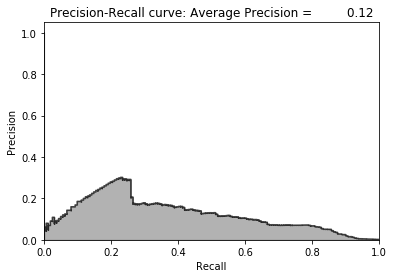

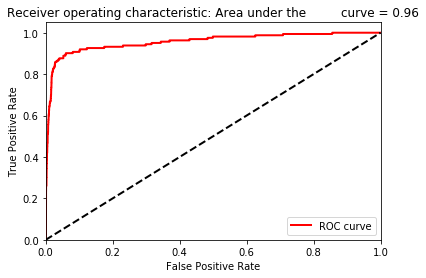

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.1406 - acc: 0.8233 - val_loss: 0.0628 - val_acc: 0.9493
Epoch 2/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0770 - acc: 0.8627 - val_loss: 0.0351 - val_acc: 0.9797
Epoch 3/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0703 - acc: 0.8629 - val_loss: 0.0340 - val_acc: 0.9650
Epoch 4/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0688 - acc: 0.8625 - val_loss: 0.0277 - val_acc: 0.9724
Epoch 5/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0622 - acc: 0.8628 - val_loss: 0.0302 - val_acc: 0.9770
Epoch 6/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0614 - acc: 0.8613 - val_loss: 0.0225 - val_acc: 0.9791
Epoch 7/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0616 - acc: 0.8595 - val

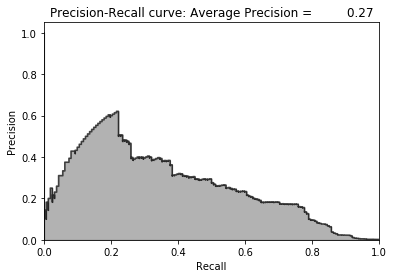

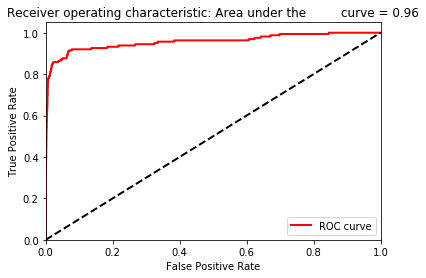

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.1776 - acc: 0.8038 - val_loss: 0.0502 - val_acc: 0.9811
Epoch 2/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0777 - acc: 0.8637 - val_loss: 0.0356 - val_acc: 0.9767
Epoch 3/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0664 - acc: 0.8627 - val_loss: 0.0326 - val_acc: 0.9606
Epoch 4/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0647 - acc: 0.8625 - val_loss: 0.0258 - val_acc: 0.9789
Epoch 5/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0636 - acc: 0.8615 - val_loss: 0.0236 - val_acc: 0.9835
Epoch 6/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0619 - acc: 0.8616 - val_loss: 0.0249 - val_acc: 0.9772
Epoch 7/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0622 - acc: 0.8593 - val

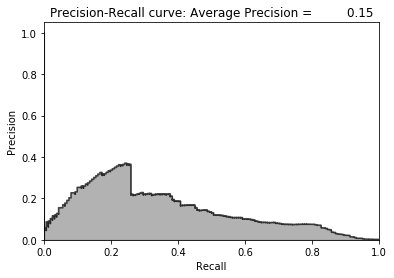

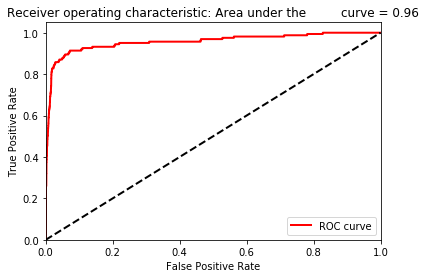

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.1519 - acc: 0.8167 - val_loss: 0.0488 - val_acc: 0.9754
Epoch 2/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0761 - acc: 0.8648 - val_loss: 0.0347 - val_acc: 0.9828
Epoch 3/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0687 - acc: 0.8624 - val_loss: 0.0288 - val_acc: 0.9807
Epoch 4/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0643 - acc: 0.8611 - val_loss: 0.0274 - val_acc: 0.9717
Epoch 5/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0629 - acc: 0.8614 - val_loss: 0.0253 - val_acc: 0.9683
Epoch 6/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0616 - acc: 0.8604 - val_loss: 0.0217 - val_acc: 0.9793
Epoch 7/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0601 - acc: 0.8614 - val

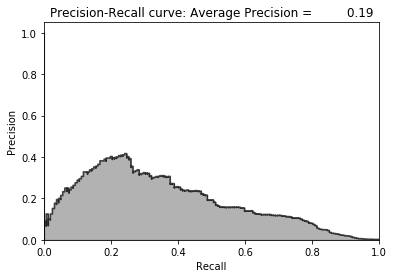

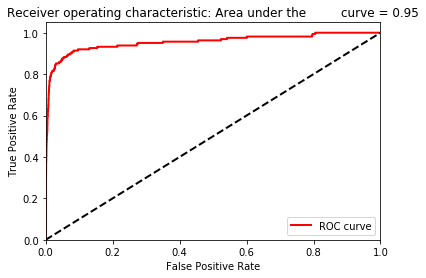

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.1685 - acc: 0.8061 - val_loss: 0.0503 - val_acc: 0.9806
Epoch 2/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0762 - acc: 0.8637 - val_loss: 0.0361 - val_acc: 0.9819
Epoch 3/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0715 - acc: 0.8630 - val_loss: 0.0301 - val_acc: 0.9840
Epoch 4/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0662 - acc: 0.8607 - val_loss: 0.0273 - val_acc: 0.9813
Epoch 5/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0638 - acc: 0.8603 - val_loss: 0.0243 - val_acc: 0.9816
Epoch 6/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0625 - acc: 0.8617 - val_loss: 0.0276 - val_acc: 0.9679
Epoch 7/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0636 - acc: 0.8585 - val

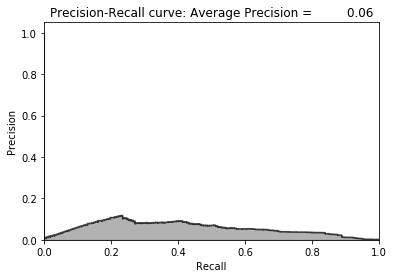

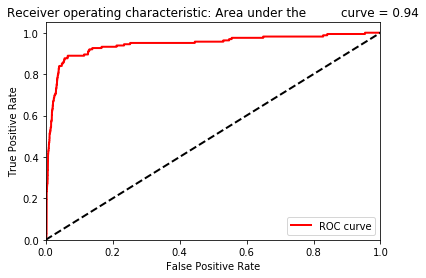

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.1526 - acc: 0.8109 - val_loss: 0.0508 - val_acc: 0.9665
Epoch 2/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0763 - acc: 0.8610 - val_loss: 0.0354 - val_acc: 0.9733
Epoch 3/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0699 - acc: 0.8606 - val_loss: 0.0325 - val_acc: 0.9715
Epoch 4/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0650 - acc: 0.8616 - val_loss: 0.0258 - val_acc: 0.9824
Epoch 5/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0631 - acc: 0.8612 - val_loss: 0.0234 - val_acc: 0.9840
Epoch 6/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0615 - acc: 0.8594 - val_loss: 0.0248 - val_acc: 0.9669
Epoch 7/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0622 - acc: 0.8598 - val

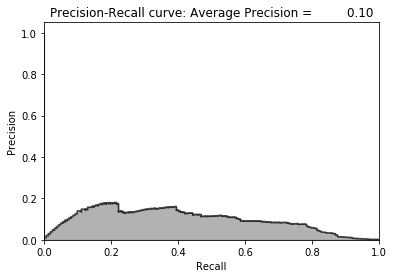

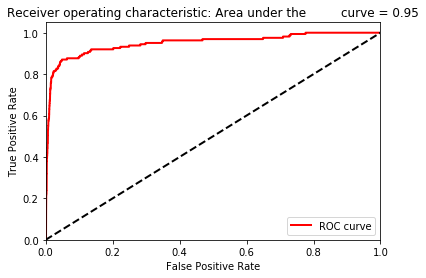

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.1527 - acc: 0.8165 - val_loss: 0.0465 - val_acc: 0.9781
Epoch 2/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0746 - acc: 0.8628 - val_loss: 0.0341 - val_acc: 0.9779
Epoch 3/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0669 - acc: 0.8628 - val_loss: 0.0286 - val_acc: 0.9784
Epoch 4/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0651 - acc: 0.8626 - val_loss: 0.0399 - val_acc: 0.9478
Epoch 5/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0642 - acc: 0.8598 - val_loss: 0.0286 - val_acc: 0.9614
Epoch 6/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0633 - acc: 0.8597 - val_loss: 0.0218 - val_acc: 0.9819
Epoch 7/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0601 - acc: 0.8607 - val

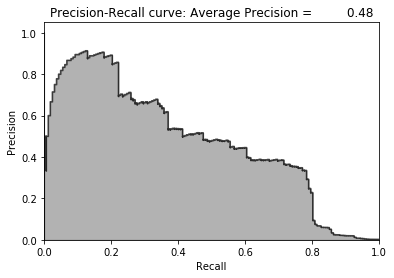

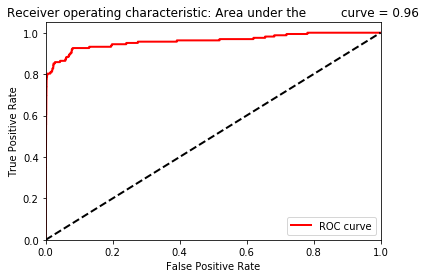

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.1747 - acc: 0.8030 - val_loss: 0.0525 - val_acc: 0.9778
Epoch 2/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0773 - acc: 0.8629 - val_loss: 0.0355 - val_acc: 0.9799
Epoch 3/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0690 - acc: 0.8609 - val_loss: 0.0297 - val_acc: 0.9804
Epoch 4/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0669 - acc: 0.8607 - val_loss: 0.0263 - val_acc: 0.9772
Epoch 5/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0618 - acc: 0.8603 - val_loss: 0.0282 - val_acc: 0.9805
Epoch 6/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0611 - acc: 0.8597 - val_loss: 0.0249 - val_acc: 0.9755
Epoch 7/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0609 - acc: 0.8598 - val

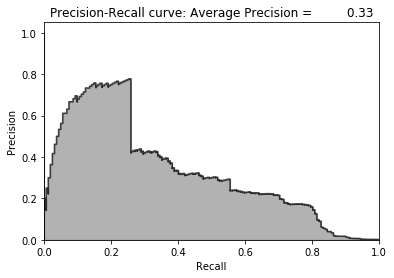

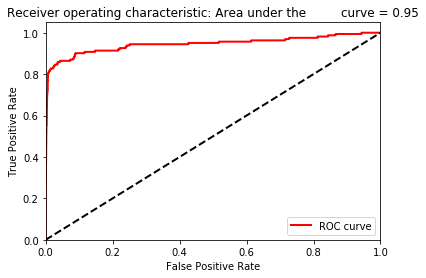

Mean average precision over 10 runs:  0.23422232742336005


[0.44623380511347305,
 0.20887085959289356,
 0.1231860615468657,
 0.26676879288109123,
 0.1460460459624458,
 0.1893583722817529,
 0.05596775101219677,
 0.09744406607019886,
 0.47689188914286923,
 0.3314556306298132]

In [20]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [21]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.23422232742336005
Coefficient of variation over 10 runs:  0.5847640220637544


[0.44623380511347305,
 0.20887085959289356,
 0.1231860615468657,
 0.26676879288109123,
 0.1460460459624458,
 0.1893583722817529,
 0.05596775101219677,
 0.09744406607019886,
 0.47689188914286923,
 0.3314556306298132]

In [22]:
# 모델 9
# 선형 활성화 함수를 가진 2-계층 노이즈 제거 과소완전 오토인코더(은닉층 27개 노드)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.2034 - acc: 0.7309 - val_loss: 0.0363 - val_acc: 0.8834
Epoch 2/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0556 - acc: 0.8340 - val_loss: 0.0358 - val_acc: 0.8780
Epoch 3/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0549 - acc: 0.8534 - val_loss: 0.0345 - val_acc: 0.9422
Epoch 4/10
190820/190820 [==============================] - 18s 97us/step - loss: 0.0535 - acc: 0.8810 - val_loss: 0.0344 - val_acc: 0.9288
Epoch 5/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.0544 - acc: 0.8718 - val_loss: 0.0338 - val_acc: 0.9529
Epoch 6/10
190820/190820 [==============================] - 16s 81us/step - loss: 0.0531 - acc: 0.8825 - val_loss: 0.0342 - val_acc: 0.9502
Epoch 7/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0527 - acc: 0.8888 - val

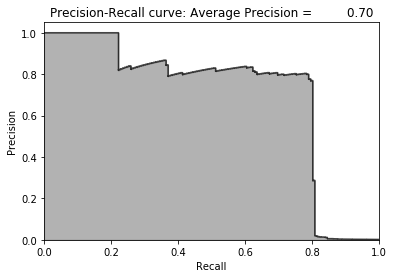

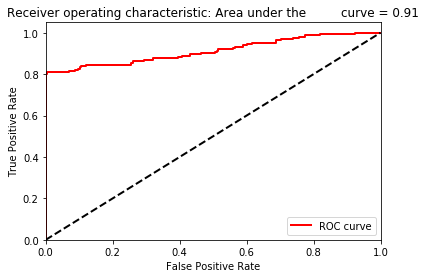

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.1298 - acc: 0.7953 - val_loss: 0.0364 - val_acc: 0.8873
Epoch 2/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0570 - acc: 0.8880 - val_loss: 0.0369 - val_acc: 0.9567
Epoch 3/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0563 - acc: 0.9054 - val_loss: 0.0370 - val_acc: 0.9593
Epoch 4/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0561 - acc: 0.9113 - val_loss: 0.0367 - val_acc: 0.9590
Epoch 5/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0551 - acc: 0.9124 - val_loss: 0.0372 - val_acc: 0.9582
Epoch 6/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0567 - acc: 0.9094 - val_loss: 0.0369 - val_acc: 0.9629
Epoch 7/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0556 - acc: 0.9122 - val

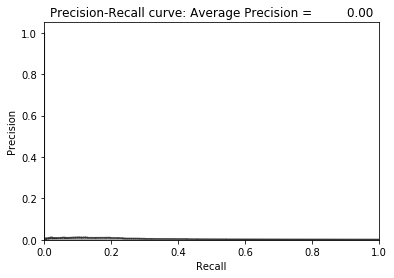

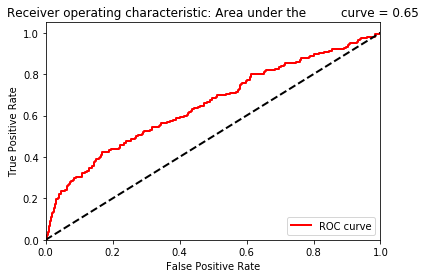

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.1520 - acc: 0.7755 - val_loss: 0.0379 - val_acc: 0.9122
Epoch 2/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0565 - acc: 0.8924 - val_loss: 0.0368 - val_acc: 0.9065
Epoch 3/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0553 - acc: 0.8803 - val_loss: 0.0364 - val_acc: 0.9481
Epoch 4/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0563 - acc: 0.9025 - val_loss: 0.0367 - val_acc: 0.9540
Epoch 5/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0559 - acc: 0.9103 - val_loss: 0.0368 - val_acc: 0.9592
Epoch 6/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0559 - acc: 0.9126 - val_loss: 0.0365 - val_acc: 0.9573
Epoch 7/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0556 - acc: 0.9123 - val

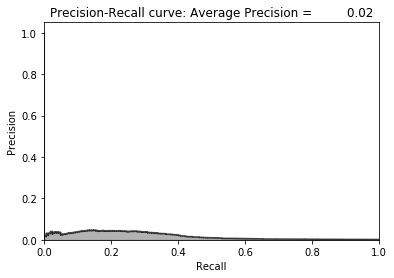

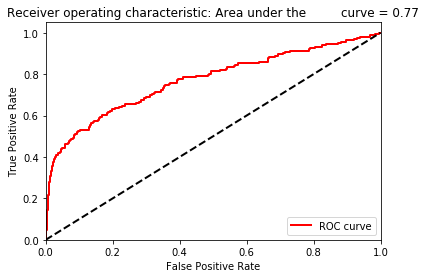

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.1818 - acc: 0.7576 - val_loss: 0.0370 - val_acc: 0.9226
Epoch 2/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0549 - acc: 0.8821 - val_loss: 0.0362 - val_acc: 0.9447
Epoch 3/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0568 - acc: 0.9014 - val_loss: 0.0387 - val_acc: 0.9549
Epoch 4/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.0562 - acc: 0.9047 - val_loss: 0.0368 - val_acc: 0.9639
Epoch 5/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0565 - acc: 0.9086 - val_loss: 0.0368 - val_acc: 0.9626
Epoch 6/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.0564 - acc: 0.9112 - val_loss: 0.0367 - val_acc: 0.9505
Epoch 7/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0557 - acc: 0.9082 - val

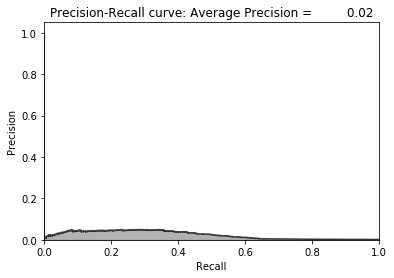

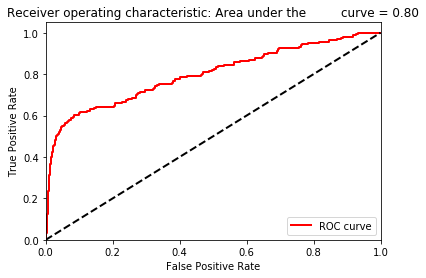

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.1367 - acc: 0.8040 - val_loss: 0.0508 - val_acc: 0.8779
Epoch 2/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0580 - acc: 0.8899 - val_loss: 0.0370 - val_acc: 0.9403
Epoch 3/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0563 - acc: 0.8963 - val_loss: 0.0367 - val_acc: 0.9543
Epoch 4/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0561 - acc: 0.9093 - val_loss: 0.0367 - val_acc: 0.9565
Epoch 5/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0558 - acc: 0.9102 - val_loss: 0.0372 - val_acc: 0.9524
Epoch 6/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0561 - acc: 0.9064 - val_loss: 0.0375 - val_acc: 0.9583
Epoch 7/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0561 - acc: 0.9118 - val

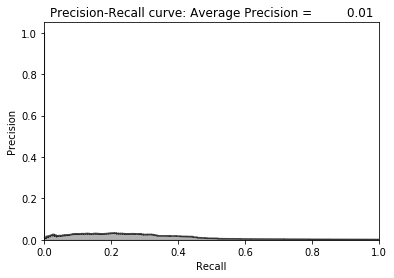

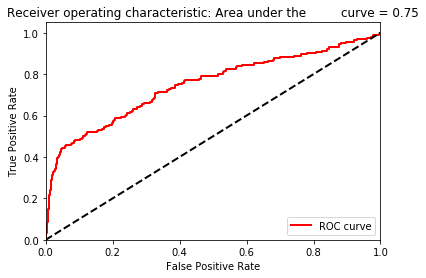

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.1430 - acc: 0.8014 - val_loss: 0.0634 - val_acc: 0.8773
Epoch 2/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0554 - acc: 0.8733 - val_loss: 0.0378 - val_acc: 0.9329
Epoch 3/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0569 - acc: 0.8986 - val_loss: 0.0367 - val_acc: 0.9564
Epoch 4/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0566 - acc: 0.9075 - val_loss: 0.0367 - val_acc: 0.9654
Epoch 5/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0553 - acc: 0.9095 - val_loss: 0.0370 - val_acc: 0.9640
Epoch 6/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0555 - acc: 0.9121 - val_loss: 0.0368 - val_acc: 0.9664
Epoch 7/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0559 - acc: 0.9105 - val

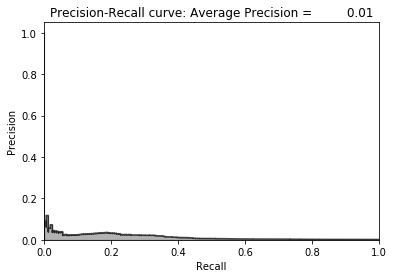

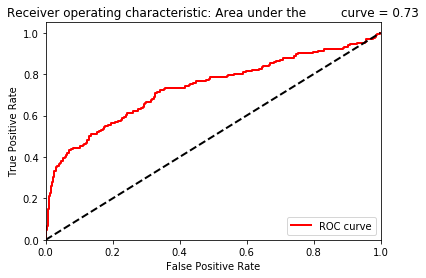

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.1387 - acc: 0.7935 - val_loss: 0.0361 - val_acc: 0.8861
Epoch 2/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0556 - acc: 0.8666 - val_loss: 0.0368 - val_acc: 0.9177
Epoch 3/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0560 - acc: 0.8893 - val_loss: 0.0368 - val_acc: 0.9468
Epoch 4/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0564 - acc: 0.9070 - val_loss: 0.0368 - val_acc: 0.9626
Epoch 5/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0556 - acc: 0.9139 - val_loss: 0.0371 - val_acc: 0.9654
Epoch 6/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0560 - acc: 0.9137 - val_loss: 0.0375 - val_acc: 0.9596
Epoch 7/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0557 - acc: 0.9145 - val

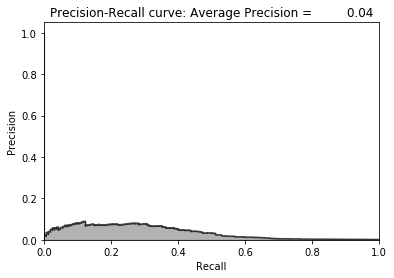

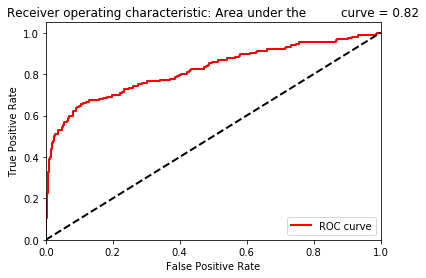

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.1432 - acc: 0.7700 - val_loss: 0.0361 - val_acc: 0.8613
Epoch 2/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0545 - acc: 0.8299 - val_loss: 0.0370 - val_acc: 0.8581
Epoch 3/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0581 - acc: 0.8758 - val_loss: 0.0369 - val_acc: 0.9385
Epoch 4/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0555 - acc: 0.8877 - val_loss: 0.0367 - val_acc: 0.9492
Epoch 5/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0561 - acc: 0.9064 - val_loss: 0.0369 - val_acc: 0.9596
Epoch 6/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0565 - acc: 0.9101 - val_loss: 0.0370 - val_acc: 0.9569
Epoch 7/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0550 - acc: 0.9075 - val

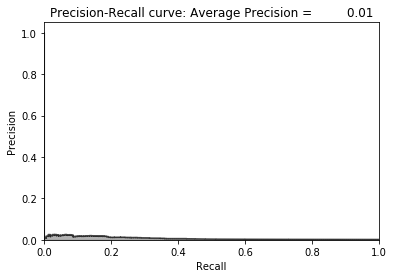

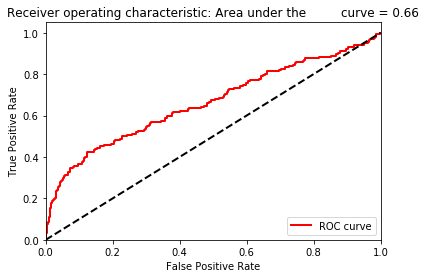

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.1425 - acc: 0.7921 - val_loss: 0.0363 - val_acc: 0.8782
Epoch 2/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0569 - acc: 0.8585 - val_loss: 0.0359 - val_acc: 0.8992
Epoch 3/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0556 - acc: 0.8523 - val_loss: 0.0355 - val_acc: 0.9076
Epoch 4/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0549 - acc: 0.8750 - val_loss: 0.0353 - val_acc: 0.9060
Epoch 5/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0537 - acc: 0.8769 - val_loss: 0.0351 - val_acc: 0.9113
Epoch 6/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0540 - acc: 0.8802 - val_loss: 0.0354 - val_acc: 0.9289
Epoch 7/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0529 - acc: 0.8846 - val

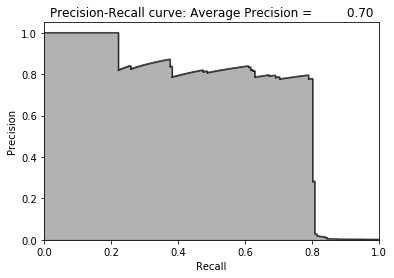

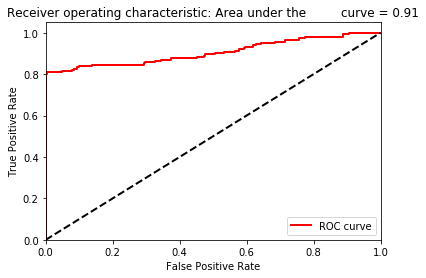

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.1358 - acc: 0.7966 - val_loss: 0.0357 - val_acc: 0.9065
Epoch 2/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0567 - acc: 0.8752 - val_loss: 0.0367 - val_acc: 0.9375
Epoch 3/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0550 - acc: 0.8819 - val_loss: 0.0363 - val_acc: 0.9462
Epoch 4/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0567 - acc: 0.8991 - val_loss: 0.0363 - val_acc: 0.9505
Epoch 5/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0549 - acc: 0.9045 - val_loss: 0.0367 - val_acc: 0.9485
Epoch 6/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0557 - acc: 0.9055 - val_loss: 0.0365 - val_acc: 0.9580
Epoch 7/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0563 - acc: 0.9129 - val

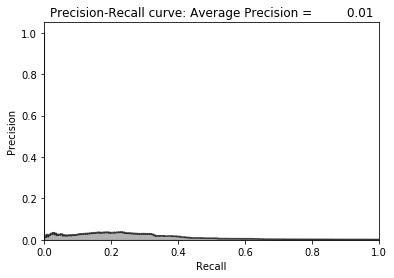

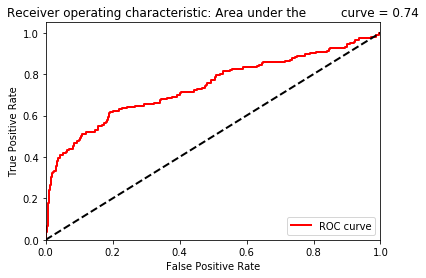

Mean average precision over 10 runs:  0.15304672623688526


[0.7005882697472066,
 0.004762771477513877,
 0.01840468886476433,
 0.023557659737688023,
 0.013242760553748218,
 0.014316510711239332,
 0.03567380177953744,
 0.007462444974726784,
 0.6984930162594067,
 0.013965338263021265]

In [23]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 선형 활성화 함수를 가진 27개 노드를 가진 은닉층 생성
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [24]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.15304672623688526
Coefficient of variation over 10 runs:  1.7861768398255964


[0.7005882697472066,
 0.004762771477513877,
 0.01840468886476433,
 0.023557659737688023,
 0.013242760553748218,
 0.014316510711239332,
 0.03567380177953744,
 0.007462444974726784,
 0.6984930162594067,
 0.013965338263021265]

In [25]:
# 모델 10
# 선형 활성화 함수를 가진 2-계층 노이즈 제거 과대완전 오토인코더(은닉층 40개 노드, 희소성 정규화, 드롭아웃 비율 : 5%)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.2013 - acc: 0.7896 - val_loss: 0.0472 - val_acc: 0.9767
Epoch 2/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0906 - acc: 0.8470 - val_loss: 0.0322 - val_acc: 0.9809
Epoch 3/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0789 - acc: 0.8482 - val_loss: 0.0261 - val_acc: 0.9802
Epoch 4/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0758 - acc: 0.8479 - val_loss: 0.0231 - val_acc: 0.9784
Epoch 5/10
190820/190820 [==============================] - 19s 97us/step - loss: 0.0739 - acc: 0.8452 - val_loss: 0.0237 - val_acc: 0.9773
Epoch 6/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0727 - acc: 0.8431 - val_loss: 0.0198 - val_acc: 0.9808
Epoch 7/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0714 - acc: 0.8443 - val

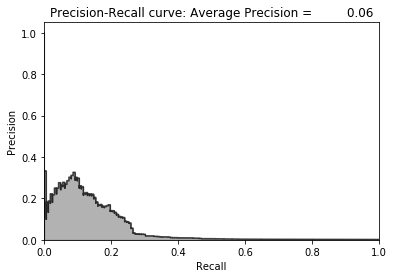

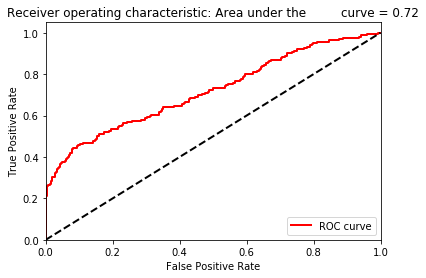

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.2411 - acc: 0.7625 - val_loss: 0.0518 - val_acc: 0.9815
Epoch 2/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0937 - acc: 0.8489 - val_loss: 0.0344 - val_acc: 0.9844
Epoch 3/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0810 - acc: 0.8485 - val_loss: 0.0272 - val_acc: 0.9835
Epoch 4/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0768 - acc: 0.8479 - val_loss: 0.0262 - val_acc: 0.9645
Epoch 5/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0766 - acc: 0.8459 - val_loss: 0.0236 - val_acc: 0.9766
Epoch 6/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0724 - acc: 0.8457 - val_loss: 0.0208 - val_acc: 0.9803
Epoch 7/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0730 - acc: 0.8431 - val

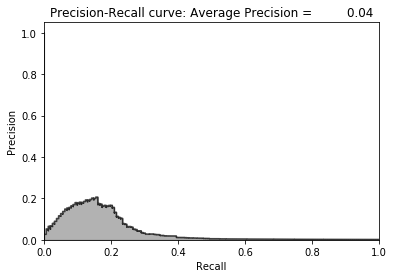

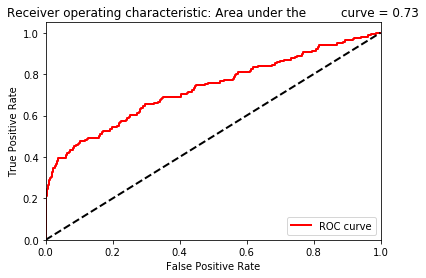

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.2003 - acc: 0.7901 - val_loss: 0.0496 - val_acc: 0.9767
Epoch 2/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0913 - acc: 0.8487 - val_loss: 0.0339 - val_acc: 0.9796
Epoch 3/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0816 - acc: 0.8487 - val_loss: 0.0271 - val_acc: 0.9787
Epoch 4/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0772 - acc: 0.8462 - val_loss: 0.0276 - val_acc: 0.9674
Epoch 5/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0739 - acc: 0.8465 - val_loss: 0.0235 - val_acc: 0.9704
Epoch 6/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0729 - acc: 0.8455 - val_loss: 0.0212 - val_acc: 0.9671
Epoch 7/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0715 - acc: 0.8459 - val

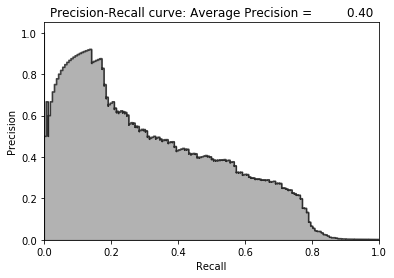

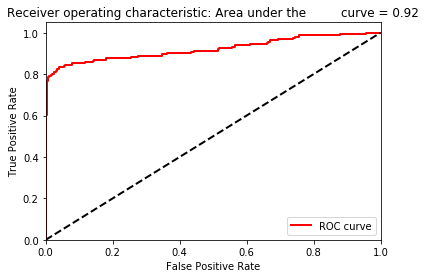

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1978 - acc: 0.7956 - val_loss: 0.0478 - val_acc: 0.9845
Epoch 2/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0928 - acc: 0.8483 - val_loss: 0.0334 - val_acc: 0.9849
Epoch 3/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0815 - acc: 0.8480 - val_loss: 0.0275 - val_acc: 0.9811
Epoch 4/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0764 - acc: 0.8467 - val_loss: 0.0243 - val_acc: 0.9768
Epoch 5/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0737 - acc: 0.8467 - val_loss: 0.0227 - val_acc: 0.9711
Epoch 6/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0749 - acc: 0.8447 - val_loss: 0.0229 - val_acc: 0.9715
Epoch 7/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0741 - acc: 0.8427 - val

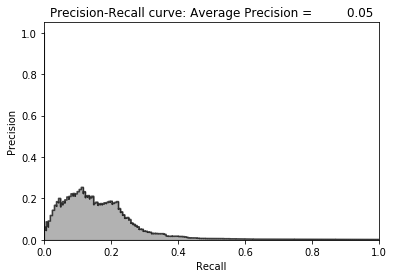

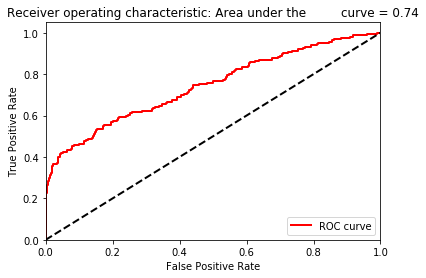

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.1813 - acc: 0.7994 - val_loss: 0.0436 - val_acc: 0.9829
Epoch 2/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0881 - acc: 0.8482 - val_loss: 0.0329 - val_acc: 0.9758
Epoch 3/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0798 - acc: 0.8464 - val_loss: 0.0268 - val_acc: 0.9726
Epoch 4/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0768 - acc: 0.8456 - val_loss: 0.0234 - val_acc: 0.9775
Epoch 5/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.0753 - acc: 0.8451 - val_loss: 0.0221 - val_acc: 0.9807
Epoch 6/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0730 - acc: 0.8452 - val_loss: 0.0231 - val_acc: 0.9689
Epoch 7/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0715 - acc: 0.8454 - val

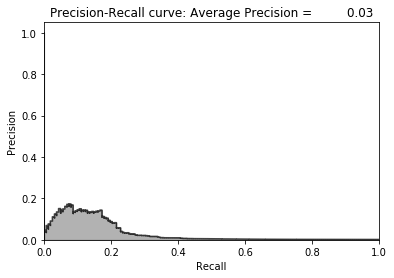

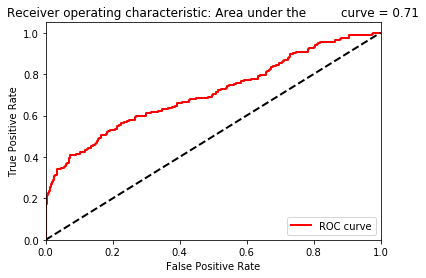

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.1717 - acc: 0.8064 - val_loss: 0.0454 - val_acc: 0.9859
Epoch 2/10
190820/190820 [==============================] - 16s 81us/step - loss: 0.0897 - acc: 0.8455 - val_loss: 0.0338 - val_acc: 0.9748
Epoch 3/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0824 - acc: 0.8452 - val_loss: 0.0284 - val_acc: 0.9735
Epoch 4/10
190820/190820 [==============================] - 16s 81us/step - loss: 0.0766 - acc: 0.8466 - val_loss: 0.0275 - val_acc: 0.9699
Epoch 5/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0752 - acc: 0.8437 - val_loss: 0.0245 - val_acc: 0.9719
Epoch 6/10
190820/190820 [==============================] - 15s 81us/step - loss: 0.0726 - acc: 0.8452 - val_loss: 0.0207 - val_acc: 0.9779
Epoch 7/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0720 - acc: 0.8456 - val

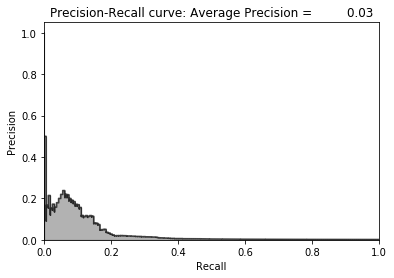

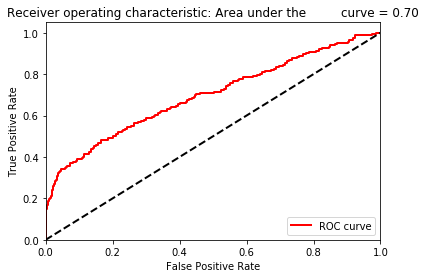

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1682 - acc: 0.8076 - val_loss: 0.0435 - val_acc: 0.9797
Epoch 2/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0899 - acc: 0.8481 - val_loss: 0.0318 - val_acc: 0.9849
Epoch 3/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0798 - acc: 0.8491 - val_loss: 0.0262 - val_acc: 0.9840
Epoch 4/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0772 - acc: 0.8453 - val_loss: 0.0245 - val_acc: 0.9730
Epoch 5/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0740 - acc: 0.8458 - val_loss: 0.0223 - val_acc: 0.9689
Epoch 6/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0725 - acc: 0.8451 - val_loss: 0.0202 - val_acc: 0.9787
Epoch 7/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0723 - acc: 0.8449 - val

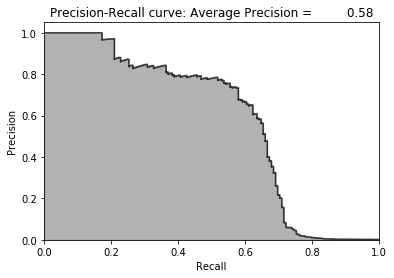

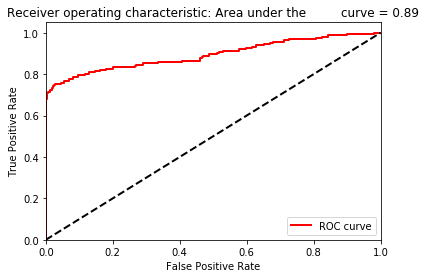

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1815 - acc: 0.8037 - val_loss: 0.0473 - val_acc: 0.9784
Epoch 2/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0914 - acc: 0.8473 - val_loss: 0.0332 - val_acc: 0.9802
Epoch 3/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0816 - acc: 0.8468 - val_loss: 0.0290 - val_acc: 0.9723
Epoch 4/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.0757 - acc: 0.8464 - val_loss: 0.0242 - val_acc: 0.9767
Epoch 5/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.0745 - acc: 0.8459 - val_loss: 0.0223 - val_acc: 0.9779
Epoch 6/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0729 - acc: 0.8458 - val_loss: 0.0216 - val_acc: 0.9765
Epoch 7/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.0717 - acc: 0.8450 - val

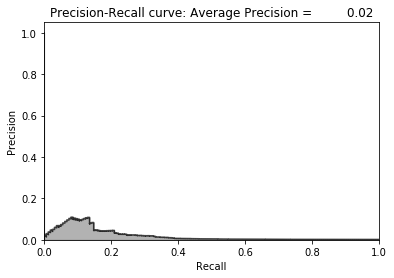

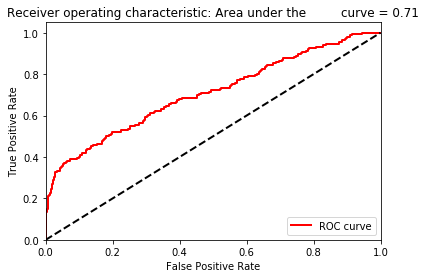

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.1822 - acc: 0.7995 - val_loss: 0.0488 - val_acc: 0.9741
Epoch 2/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.0889 - acc: 0.8479 - val_loss: 0.0319 - val_acc: 0.9770
Epoch 3/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.0796 - acc: 0.8467 - val_loss: 0.0277 - val_acc: 0.9789
Epoch 4/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.0759 - acc: 0.8452 - val_loss: 0.0246 - val_acc: 0.9749
Epoch 5/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.0747 - acc: 0.8435 - val_loss: 0.0215 - val_acc: 0.9811
Epoch 6/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.0735 - acc: 0.8444 - val_loss: 0.0235 - val_acc: 0.9768
Epoch 7/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0732 - acc: 0.8440 - val

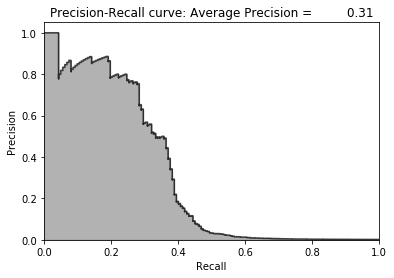

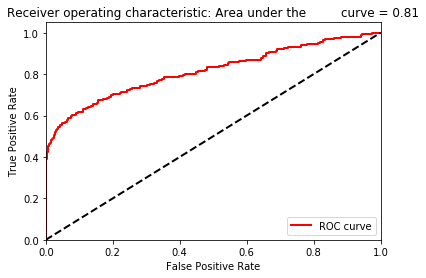

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.1688 - acc: 0.8074 - val_loss: 0.0441 - val_acc: 0.9822
Epoch 2/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0874 - acc: 0.8491 - val_loss: 0.0304 - val_acc: 0.9842
Epoch 3/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0832 - acc: 0.8463 - val_loss: 0.0261 - val_acc: 0.9815
Epoch 4/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.0756 - acc: 0.8459 - val_loss: 0.0266 - val_acc: 0.9611
Epoch 5/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0742 - acc: 0.8449 - val_loss: 0.0215 - val_acc: 0.9806
Epoch 6/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.0719 - acc: 0.8458 - val_loss: 0.0222 - val_acc: 0.9723
Epoch 7/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.0725 - acc: 0.8445 - val

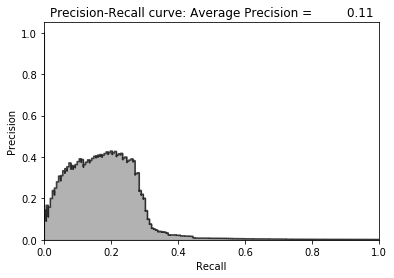

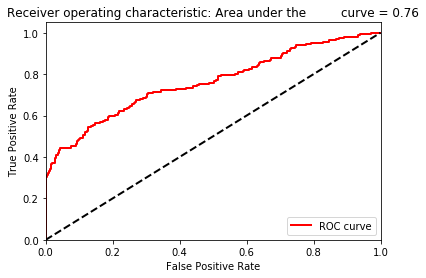

Mean average precision over 10 runs:  0.1646558400027417


[0.058767976651351216,
 0.04244585742955313,
 0.39989302117931136,
 0.053374964811279096,
 0.03330524078237183,
 0.034877570820861195,
 0.5791220552270487,
 0.02015341669839009,
 0.3114489693177255,
 0.11316932710952471]

In [26]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 선형 활성화 함수 가진 40개 노드를 가진 은닉층 생성
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [27]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.1646558400027417
Coefficient of variation over 10 runs:  1.1277746342633206


[0.058767976651351216,
 0.04244585742955313,
 0.39989302117931136,
 0.053374964811279096,
 0.03330524078237183,
 0.034877570820861195,
 0.5791220552270487,
 0.02015341669839009,
 0.3114489693177255,
 0.11316932710952471]

In [28]:
# 모델 11
# ReLU 활성화 함수를 가진 2-계층 노이즈 제거 과대완전 오토인코더(은닉층 40개 노드, 희소성 정규화, 드롭아웃 비율 : 5%)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 96us/step - loss: 0.3031 - acc: 0.6522 - val_loss: 0.0857 - val_acc: 0.8910
Epoch 2/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1849 - acc: 0.7218 - val_loss: 0.0637 - val_acc: 0.9015
Epoch 3/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.1677 - acc: 0.7237 - val_loss: 0.0530 - val_acc: 0.9009
Epoch 4/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1556 - acc: 0.7269 - val_loss: 0.0486 - val_acc: 0.8963
Epoch 5/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1537 - acc: 0.7284 - val_loss: 0.0444 - val_acc: 0.9027
Epoch 6/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1468 - acc: 0.7277 - val_loss: 0.0404 - val_acc: 0.9046
Epoch 7/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1419 - acc: 0.7297 - val

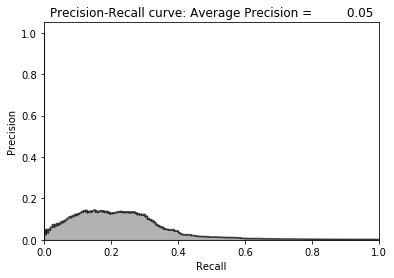

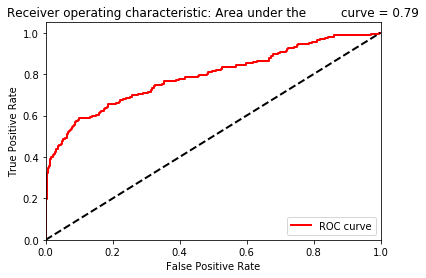

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.2885 - acc: 0.6533 - val_loss: 0.0822 - val_acc: 0.8847
Epoch 2/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.1824 - acc: 0.7182 - val_loss: 0.0701 - val_acc: 0.8839
Epoch 3/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1661 - acc: 0.7252 - val_loss: 0.0527 - val_acc: 0.9069
Epoch 4/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1589 - acc: 0.7279 - val_loss: 0.0458 - val_acc: 0.9079
Epoch 5/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.1521 - acc: 0.7295 - val_loss: 0.0422 - val_acc: 0.9136
Epoch 6/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.1475 - acc: 0.7320 - val_loss: 0.0433 - val_acc: 0.9046
Epoch 7/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1451 - acc: 0.7313 - val

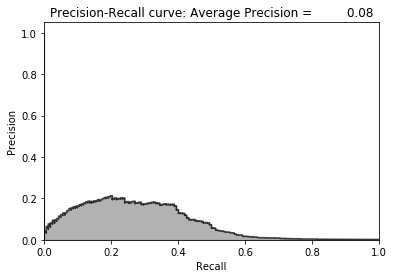

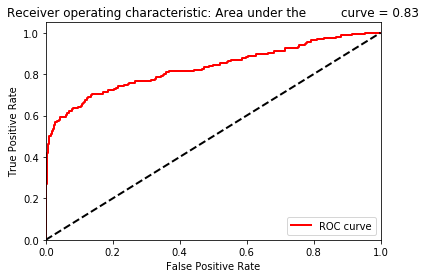

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.2930 - acc: 0.6486 - val_loss: 0.0789 - val_acc: 0.8892
Epoch 2/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1809 - acc: 0.7173 - val_loss: 0.0607 - val_acc: 0.8996
Epoch 3/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1656 - acc: 0.7228 - val_loss: 0.0549 - val_acc: 0.8819
Epoch 4/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1585 - acc: 0.7262 - val_loss: 0.0458 - val_acc: 0.9075
Epoch 5/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.1504 - acc: 0.7274 - val_loss: 0.0410 - val_acc: 0.9136
Epoch 6/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.1443 - acc: 0.7282 - val_loss: 0.0381 - val_acc: 0.9148
Epoch 7/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1439 - acc: 0.7309 - val

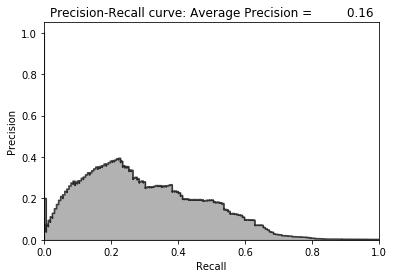

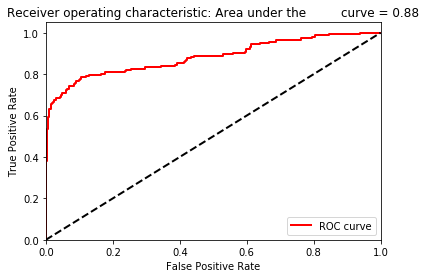

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 95us/step - loss: 0.3058 - acc: 0.6467 - val_loss: 0.0848 - val_acc: 0.8794
Epoch 2/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.1863 - acc: 0.7159 - val_loss: 0.0623 - val_acc: 0.8956
Epoch 3/10
190820/190820 [==============================] - 17s 92us/step - loss: 0.1657 - acc: 0.7229 - val_loss: 0.0521 - val_acc: 0.9027
Epoch 4/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.1571 - acc: 0.7254 - val_loss: 0.0460 - val_acc: 0.9109
Epoch 5/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.1505 - acc: 0.7266 - val_loss: 0.0412 - val_acc: 0.9098
Epoch 6/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1473 - acc: 0.7281 - val_loss: 0.0394 - val_acc: 0.9070
Epoch 7/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.1435 - acc: 0.7286 - val

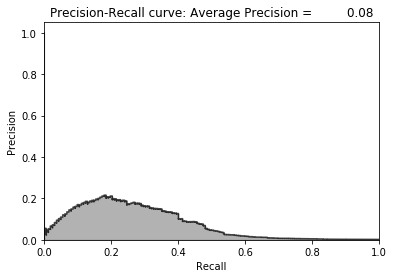

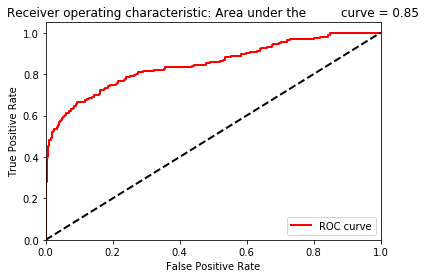

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 96us/step - loss: 0.2963 - acc: 0.6413 - val_loss: 0.0858 - val_acc: 0.8753
Epoch 2/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.1849 - acc: 0.7120 - val_loss: 0.0639 - val_acc: 0.8924
Epoch 3/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.1681 - acc: 0.7189 - val_loss: 0.0528 - val_acc: 0.8947
Epoch 4/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.1564 - acc: 0.7235 - val_loss: 0.0456 - val_acc: 0.9054
Epoch 5/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1508 - acc: 0.7261 - val_loss: 0.0424 - val_acc: 0.9078
Epoch 6/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.1491 - acc: 0.7263 - val_loss: 0.0640 - val_acc: 0.8652
Epoch 7/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.1448 - acc: 0.7263 - val

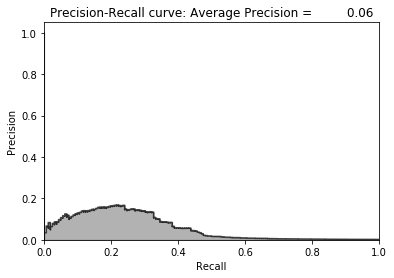

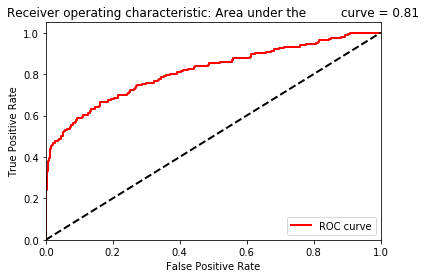

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 98us/step - loss: 0.3062 - acc: 0.6429 - val_loss: 0.0827 - val_acc: 0.8827
Epoch 2/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1822 - acc: 0.7180 - val_loss: 0.0639 - val_acc: 0.8971
Epoch 3/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1662 - acc: 0.7236 - val_loss: 0.0512 - val_acc: 0.9030
Epoch 4/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1550 - acc: 0.7247 - val_loss: 0.0464 - val_acc: 0.9040
Epoch 5/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.1496 - acc: 0.7249 - val_loss: 0.0416 - val_acc: 0.9051
Epoch 6/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.1450 - acc: 0.7270 - val_loss: 0.0385 - val_acc: 0.9114
Epoch 7/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1428 - acc: 0.7287 - val

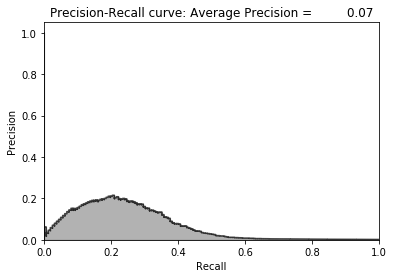

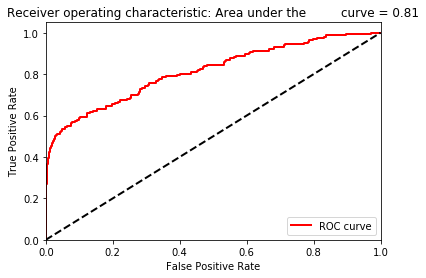

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 102us/step - loss: 0.3036 - acc: 0.6426 - val_loss: 0.0842 - val_acc: 0.8832
Epoch 2/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1853 - acc: 0.7153 - val_loss: 0.0634 - val_acc: 0.8978
Epoch 3/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1643 - acc: 0.7233 - val_loss: 0.0545 - val_acc: 0.8972
Epoch 4/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1552 - acc: 0.7278 - val_loss: 0.0476 - val_acc: 0.8983
Epoch 5/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1501 - acc: 0.7299 - val_loss: 0.0432 - val_acc: 0.9066
Epoch 6/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1459 - acc: 0.7311 - val_loss: 0.0396 - val_acc: 0.9081
Epoch 7/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1443 - acc: 0.7317 - va

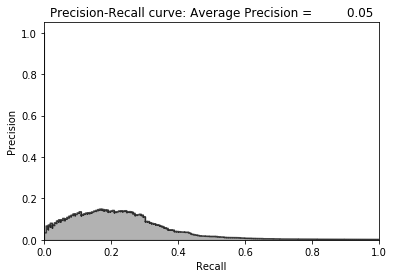

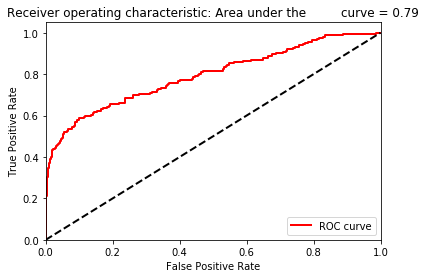

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.3023 - acc: 0.6421 - val_loss: 0.0821 - val_acc: 0.8855
Epoch 2/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1825 - acc: 0.7147 - val_loss: 0.0611 - val_acc: 0.9001
Epoch 3/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1640 - acc: 0.7250 - val_loss: 0.0515 - val_acc: 0.8915
Epoch 4/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1564 - acc: 0.7278 - val_loss: 0.0458 - val_acc: 0.9075
Epoch 5/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1487 - acc: 0.7292 - val_loss: 0.0449 - val_acc: 0.9048
Epoch 6/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1462 - acc: 0.7275 - val_loss: 0.0454 - val_acc: 0.8981
Epoch 7/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1428 - acc: 0.7286 - val

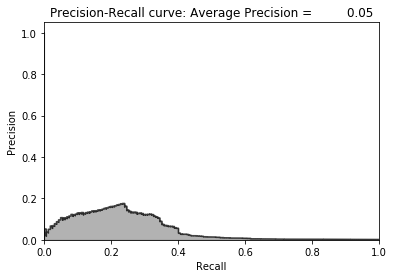

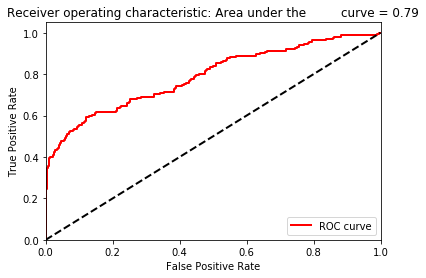

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.2984 - acc: 0.6475 - val_loss: 0.0813 - val_acc: 0.8833
Epoch 2/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1816 - acc: 0.7170 - val_loss: 0.0599 - val_acc: 0.8925
Epoch 3/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1650 - acc: 0.7228 - val_loss: 0.0513 - val_acc: 0.8979
Epoch 4/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.1524 - acc: 0.7259 - val_loss: 0.0543 - val_acc: 0.8939
Epoch 5/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1468 - acc: 0.7262 - val_loss: 0.0389 - val_acc: 0.9057
Epoch 6/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1513 - acc: 0.7259 - val_loss: 0.0405 - val_acc: 0.8989
Epoch 7/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.1423 - acc: 0.7269 - val

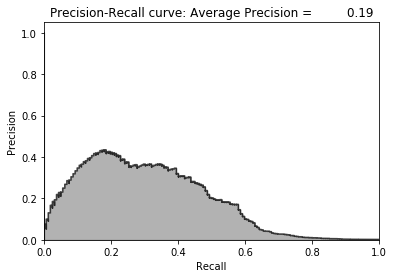

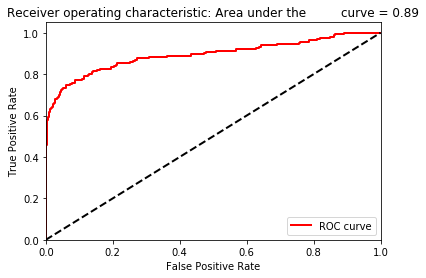

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.3088 - acc: 0.6403 - val_loss: 0.0873 - val_acc: 0.8830
Epoch 2/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.1867 - acc: 0.7129 - val_loss: 0.0642 - val_acc: 0.8889
Epoch 3/10
190820/190820 [==============================] - 17s 92us/step - loss: 0.1671 - acc: 0.7222 - val_loss: 0.0506 - val_acc: 0.9007
Epoch 4/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.1556 - acc: 0.7276 - val_loss: 0.0457 - val_acc: 0.9045
Epoch 5/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.1473 - acc: 0.7273 - val_loss: 0.0404 - val_acc: 0.9033
Epoch 6/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.1449 - acc: 0.7298 - val_loss: 0.0380 - val_acc: 0.9046
Epoch 7/10
190820/190820 [==============================] - 17s 92us/step - loss: 0.1428 - acc: 0.7292 - va

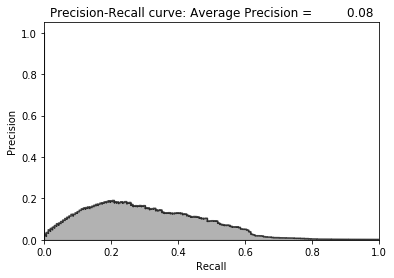

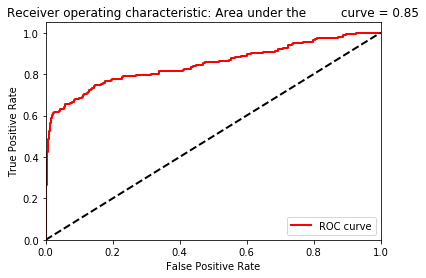

Mean average precision over 10 runs:  0.08537332185998554


[0.046917598293571595,
 0.0824002175769913,
 0.1558904361084493,
 0.07615337786550096,
 0.05667047656456427,
 0.06815792898231161,
 0.0479664784670308,
 0.05161478930318387,
 0.18965901240170405,
 0.0783029030365478]

In [29]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 선형 활성화 함수를 가진 40개 노드를 가진 은닉층 생성
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [30]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.08537332185998554
Coefficient of variation over 10 runs:  0.5384276913816174


[0.046917598293571595,
 0.0824002175769913,
 0.1558904361084493,
 0.07615337786550096,
 0.05667047656456427,
 0.06815792898231161,
 0.0479664784670308,
 0.05161478930318387,
 0.18965901240170405,
 0.0783029030365478]